# Introduction

How much does what is included in the annotation set matter?

In [1]:
import seaborn
import scipy
import anndata
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot, cm
import sys
import pysam
from collections import Counter
from IPython import display

import upsetplot

In [2]:
pandas.options.display.max_rows = 300

In [3]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR362YDM_26m_nuc'

In [4]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [5]:
v29_genome_dir = Path("~/proj/genome/").expanduser()
v29_store = pandas.HDFStore(v29_genome_dir / "GRCh38-V29-male" / "GRCh38-V29-male.h5")
v29_gtf = v29_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v29_store.close()

v29_gene_base_to_id = {}
v29_gene_id_to_name = {}
v29_gene_id_to_type = {}
for i, row in v29_gtf.iterrows():
    v29_gene_base_to_id[row.gene_id.split('.')[0]] = row.gene_id
    v29_gene_id_to_name[row.gene_id] = row.gene_name
    v29_gene_id_to_type[row.gene_id] = row.gene_type

def calculate_v29_gene_base(gene_id):
    gene_base = gene_id.split('.')[0]
    if gene_id.endswith("_PAR_Y"):
        gene_base += "_PAR_Y"
    return gene_base
v29_gtf['gene_base'] = v29_gtf['gene_id'].apply(calculate_v29_gene_base)

In [6]:
v32m_genome_dir = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/").expanduser()
v32m_store = pandas.HDFStore(v32m_genome_dir / "GRCh38-arc2.0-2.7.8a" / "GRCh38-arc2.0-2.7.8a.h5")
v32m_gtf = v32m_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v32m_store.close()

v32m_gtf.columns = ['gene_base', 'gene_name', 'gene_type']
v32m_gtf['gene_id'] = v32m_gtf['gene_base'].apply(lambda x: v29_gene_base_to_id.get(x, x))

v32m_gene_id_to_name = {}
v32m_gene_id_to_type = {}
for i, row in v32m_gtf.iterrows():
    v32m_gene_id_to_name[row.gene_id] = row.gene_name
    v32m_gene_id_to_type[row.gene_id] = row.gene_type

In [7]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered", multiread="Unique"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "GeneFull_Ex50pAS", "SJ"]
    MULTIREAD_MATRIX = {
    "Unique": "matrix.mtx",
    "Rescue": "UniqueAndMult-Rescue.mtx",
    "EM": "UniqueAndMult-EM.mtx",
    }
    assert multiread in MULTIREAD_MATRIX

    analysis_dir = Path(analysis_dir)
    
    solo_dir = analysis_dir / "Solo.out" / quantification 
    solo = scanpy.read_mtx(solo_dir / "raw" / MULTIREAD_MATRIX[multiread]).T
    solo_vars = pandas.read_csv(
        solo_dir / "raw" / "features.tsv", header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "raw" / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]
    
    if mode == "filtered":
        solo_obs = pandas.read_csv(
            solo_dir / mode / "barcodes.tsv", header=None, sep="\t"
        ).values.T[0]
        solo = solo[solo_obs,:]
        

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



I also learned that there's some gene base ids that have two version varients. (One example)
<table>
<tr><td>gene_id 	</td><td>gene_name 	</td><td>gene_type</td></tr>
<tr><td>ENSG00000169084.13 	</td><td>DHRSX 	</td><td>protein_coding</td></tr>
    <tr><td>ENSG00000169084.13_PAR_Y 	</td><td>DHRSX 	</td><td>protein_coding</td></tr>
</table>

# Load Datasets

In [8]:
algorithm_roots = {
    'tenx solo uniq': (Path("tenxsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "Unique"),
    'tenx solo rescue': (Path("tenxsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "Rescue"),
    'tenx solo em': (Path("tenxsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "EM"),
    
    'encode full solo uniq': (Path("fullsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "Unique"),
    'encode full solo rescue': (Path("fullsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "Rescue"),
    'encode full solo em': (Path("fullsolo_multi_dev_EoI_2.7.9a_2021-09-10"),  "GeneFull_Ex50pAS", "filtered", "EM"),

    'encode minimal solo uniq': (Path("minimalsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "Unique"),
    'encode minimal solo rescue': (Path("minimalsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "Rescue"),
    'encode minimal solo em': (Path("minimalsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "EM"),
}

In [9]:
algorithm_filtered = {}
for algorithm in algorithm_roots:
    root, quantification, filtering, multiread = algorithm_roots[algorithm]
    print("loading {}".format(algorithm))
    algorithm_filtered[algorithm] = scanpy_load_solo278a_mtx(root, quantification, filtering, multiread)
    print(algorithm, algorithm_filtered[algorithm].shape, algorithm_filtered[algorithm].X.sum())

loading tenx solo uniq


Trying to set attribute `.obs` of view, copying.


tenx solo uniq (12045, 36601) 61542976.0
loading tenx solo rescue


Trying to set attribute `.obs` of view, copying.


tenx solo rescue (12045, 36601) 63206704.0
loading tenx solo em


Trying to set attribute `.obs` of view, copying.


tenx solo em (12045, 36601) 63206704.0
loading encode full solo uniq


Trying to set attribute `.obs` of view, copying.


encode full solo uniq (11889, 59526) 59423064.0
loading encode full solo rescue


Trying to set attribute `.obs` of view, copying.


encode full solo rescue (11889, 59526) 63691024.0
loading encode full solo em


Trying to set attribute `.obs` of view, copying.


encode full solo em (11889, 59526) 63691020.0
loading encode minimal solo uniq


Trying to set attribute `.obs` of view, copying.


encode minimal solo uniq (12009, 28249) 58462710.0
loading encode minimal solo rescue


Trying to set attribute `.obs` of view, copying.


encode minimal solo rescue (12009, 28249) 61124110.0
loading encode minimal solo em


Trying to set attribute `.obs` of view, copying.


encode minimal solo em (12009, 28249) 61124110.0


# Add (faked) version to 10x annotation

The 10x provided annotation GTF file, based on GENCODE V32, has the gene version number removed, to make later comparisons easier I added the gene version number from my V29 GTF on to the V32 gene base ids.

(Gene base = ENSG00000243485)

(Gene id with version = ENSG00000243485.5)

In [10]:
algorithm_filtered['tenx solo uniq'].var_names[:5]

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945'],
      dtype='object')

In [11]:
for algorithm in algorithm_filtered:
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var_names = v32m_gtf.set_index('gene_base').reindex(algorithm_filtered[algorithm].var_names.to_list())['gene_id']

In [12]:
algorithm_filtered['tenx solo uniq'].var_names[:5]

Index(['ENSG00000243485.5', 'ENSG00000237613.2', 'ENSG00000186092.6',
       'ENSG00000238009.6', 'ENSG00000239945.1'],
      dtype='object', name='gene_id')

# Remove version from ENCODE annotations

In [13]:
#algorithm_filtered['encode minimal solo uniq'].var_names

In [14]:
#for algorithm in algorithm_filtered:
#    if algorithm != 'tenx solo uniq':
#        algorithm_filtered[algorithm].var_names = [x.split('.')[0] for x in algorithm_filtered[algorithm].var_names]


In [15]:
#algorithm_filtered['encode minimal solo uniq'].var_names

# Cell barcodes in common

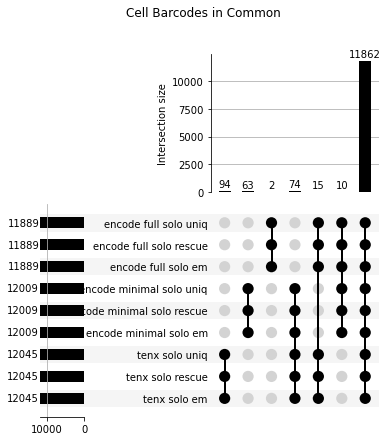

In [16]:
algorithm_cell_barcodes = {}
for algorithm in algorithm_filtered:
    algorithm_cell_barcodes[algorithm] = algorithm_filtered[algorithm].obs_names

common_cell_barcode_set = upsetplot.from_contents(algorithm_cell_barcodes)
f = pyplot.figure()
f.suptitle("Cell Barcodes in Common")
_ = upsetplot.plot(common_cell_barcode_set, fig=f, show_counts=True)


# Gene IDs in common

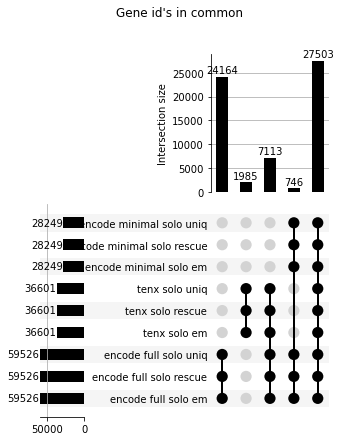

In [17]:
algorithm_gene_base_ids = {}
for algorithm in algorithm_filtered:
    algorithm_gene_base_ids[algorithm] = set(algorithm_filtered[algorithm].var_names)

common_gene_base_contents = upsetplot.from_contents(algorithm_gene_base_ids)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
f = pyplot.figure()
f.suptitle("Gene id's in common")
_ = upsetplot.plot(common_gene_base_contents, fig=f, show_counts=True)

# What are some of those genes in tenx & encode full 

In [18]:
common_gene_base_contents

id
tenx solo uniq tenx solo rescue tenx solo em encode full solo uniq encode full solo rescue encode full solo em encode minimal solo uniq encode minimal solo rescue encode minimal solo em                    
True           True             True         True                  True                    True                True                     True                       True                     ENSG00000228873.1
                                                                                                                                                                   True                    ENSG00000171368.11
                                                                                                                                                                   True                     ENSG00000248265.1
                                                                                                                                                                   True                    ENSG00000177707.10
                                                                                                                                                                   True                     ENSG00000280164.1
...                                                                                                                                                                                                       ...
False          False            False        True                  True                    True                False                    False                      False                    ENSG00000214027.3
                                                                                                                                                                   False                    ENSG00000213761.4
                                                                                                                                                                   False                    ENSG00000229919.3
                                                                                                                                                                   False                    ENSG00000249002.2
                                                                                                                                                                   False                    ENSG00000271205.1

[61511 rows x 1 columns]

In [19]:
not_in_encode_minimal = common_gene_base_contents.loc[True,True,True,True,True,True,False,False,False]['id'].values

changed_between_versions = []
for gene_base in not_in_encode_minimal:
    changed_between_versions.append({
        'gene_base': gene_base,
        'v29_type': v29_gene_id_to_type[gene_base],
        'v32_type': v32m_gene_id_to_type[gene_base],
    })
    
changed_between_versions = pandas.DataFrame(changed_between_versions)

<ipython-input-19-f9b6b4ac231c>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  not_in_encode_minimal = common_gene_base_contents.loc[True,True,True,True,True,True,False,False,False]['id'].values


In [20]:
changed_between_versions[changed_between_versions['v29_type'] != changed_between_versions['v32_type']]

gene_base              v29_type v32_type
0     ENSG00000227554.1             antisense   lncRNA
1     ENSG00000260366.1     sense_overlapping   lncRNA
2     ENSG00000254687.1             antisense   lncRNA
3     ENSG00000260121.1             antisense   lncRNA
4     ENSG00000236292.1             antisense   lncRNA
...                 ...                   ...      ...
7108  ENSG00000234156.1             antisense   lncRNA
7109  ENSG00000255182.2  processed_transcript   lncRNA
7110  ENSG00000229882.1             antisense   lncRNA
7111  ENSG00000275476.1             antisense   lncRNA
7112  ENSG00000234235.1             antisense   lncRNA

[7113 rows x 3 columns]

In [21]:
changed_between_versions[changed_between_versions['v29_type'] != changed_between_versions['v32_type']]['v32_type'].unique()

array(['lncRNA', 'protein_coding'], dtype=object)

# Build list of cells and gene ids in common between all runs

In [22]:
common_cell_barcode_set = None
for algorithm in algorithm_filtered:
    if common_cell_barcode_set is None:
        common_cell_barcode_set = set(algorithm_filtered[algorithm].obs_names)
    else:
        common_cell_barcode_set = common_cell_barcode_set.intersection(algorithm_filtered[algorithm].obs_names)

print('common_cell_barcode_set', len(common_cell_barcode_set))
common_cell_barcodes = [x for x in algorithm_filtered['encode full solo uniq'].obs_names if x in common_cell_barcode_set]
print('common_cell_barcodes', len(common_cell_barcodes))


common_cell_barcode_set 11862
common_cell_barcodes 11862


In [23]:
common_gene_id_set = None
for algorithm in algorithm_filtered:
    #if algorithm == 'tenx solo uniq':
    #    continue
    if common_gene_id_set is None:
        common_gene_id_set = set(algorithm_filtered[algorithm].var_names)
    else:
        common_gene_id_set = common_gene_id_set.intersection(algorithm_filtered[algorithm].var_names)

print("common_gene_id_set", len(common_gene_id_set), len(set(common_gene_id_set)))
common_gene_ids = [x for x in algorithm_filtered['encode full solo uniq'].var_names if x in common_gene_id_set]
print("common_gene_ids", len(common_gene_ids), len(set(common_gene_ids)))

common_gene_id_set 27503 27503
common_gene_ids 27503 27503


In [24]:
#tenx_gene_base = set(algorithm_filtered['tenx solo uniq'].var_names)
#v29_common_gene_base = [x.split('.')[0] for x in algorithm_filtered['encode full solo uniq'].var_names if x.split('.')[0] in tenx_gene_base and x in common_gene_ids]
#v29_common_gene_ids = [x for x in algorithm_filtered['encode full solo uniq'].var_names if x.split('.')[0] in tenx_gene_base and x in common_gene_ids]
#print(len(v29_common_gene_base), v29_common_gene_base[:5])

In [25]:
algorithm_common = {}
for algorithm in algorithm_filtered:
    algorithm_common[algorithm] = algorithm_filtered[algorithm][common_cell_barcodes, common_gene_ids]
    print(algorithm, algorithm_common[algorithm].shape, algorithm_common[algorithm].X.sum())

tenx solo uniq (11862, 27503) 59134320.0
tenx solo rescue (11862, 27503) 60614870.0
tenx solo em (11862, 27503) 60658250.0
encode full solo uniq (11862, 27503) 56348330.0
encode full solo rescue (11862, 27503) 59105664.0
encode full solo em (11862, 27503) 59340104.0
encode minimal solo uniq (11862, 27503) 58114092.0
encode minimal solo rescue (11862, 27503) 60065490.0
encode minimal solo em (11862, 27503) 60099930.0


# Compute correlations of cells in common between all methods

In [26]:
def compute_spearman_anndata(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.to_df().T
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.to_df().T

    #print(left.shape[0])
    #print(left[0].shape)
    #print(right[0].shape)
    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


def compute_correlations(table):
    programs = list(table.keys())
    correlations = {}
    dense = {}
    for name_x in programs:
        dense[name_x] = table[name_x].to_df().T

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            print("Processing {} {}".format(name_x, name_y))
            cs_cors = compute_spearman_anndata(dense[name_x], dense[name_y])
            correlations.setdefault(name_x, {})[name_y] = cs_cors
    return correlations

algorithm_correlations = compute_correlations(algorithm_common)

Processing tenx solo uniq tenx solo uniq
Processing tenx solo uniq tenx solo rescue
Processing tenx solo uniq tenx solo em
Processing tenx solo uniq encode full solo uniq
Processing tenx solo uniq encode full solo rescue
Processing tenx solo uniq encode full solo em
Processing tenx solo uniq encode minimal solo uniq
Processing tenx solo uniq encode minimal solo rescue
Processing tenx solo uniq encode minimal solo em
Processing tenx solo rescue tenx solo rescue
Processing tenx solo rescue tenx solo em
Processing tenx solo rescue encode full solo uniq
Processing tenx solo rescue encode full solo rescue
Processing tenx solo rescue encode full solo em
Processing tenx solo rescue encode minimal solo uniq
Processing tenx solo rescue encode minimal solo rescue
Processing tenx solo rescue encode minimal solo em
Processing tenx solo em tenx solo em
Processing tenx solo em encode full solo uniq
Processing tenx solo em encode full solo rescue
Processing tenx solo em encode full solo em
Processing

In [27]:
def plot_cell_correlation_histogram(table, title=None, bins=50, programs=None):
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)
    if title is not None:
        f.suptitle(title.format(metric=metric))

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            spearman = numpy.array(table[name_x][name_y])
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCount {count}', xy=(0.1, 0.6), xycoords='axes fraction')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    #f.tight_layout()
    

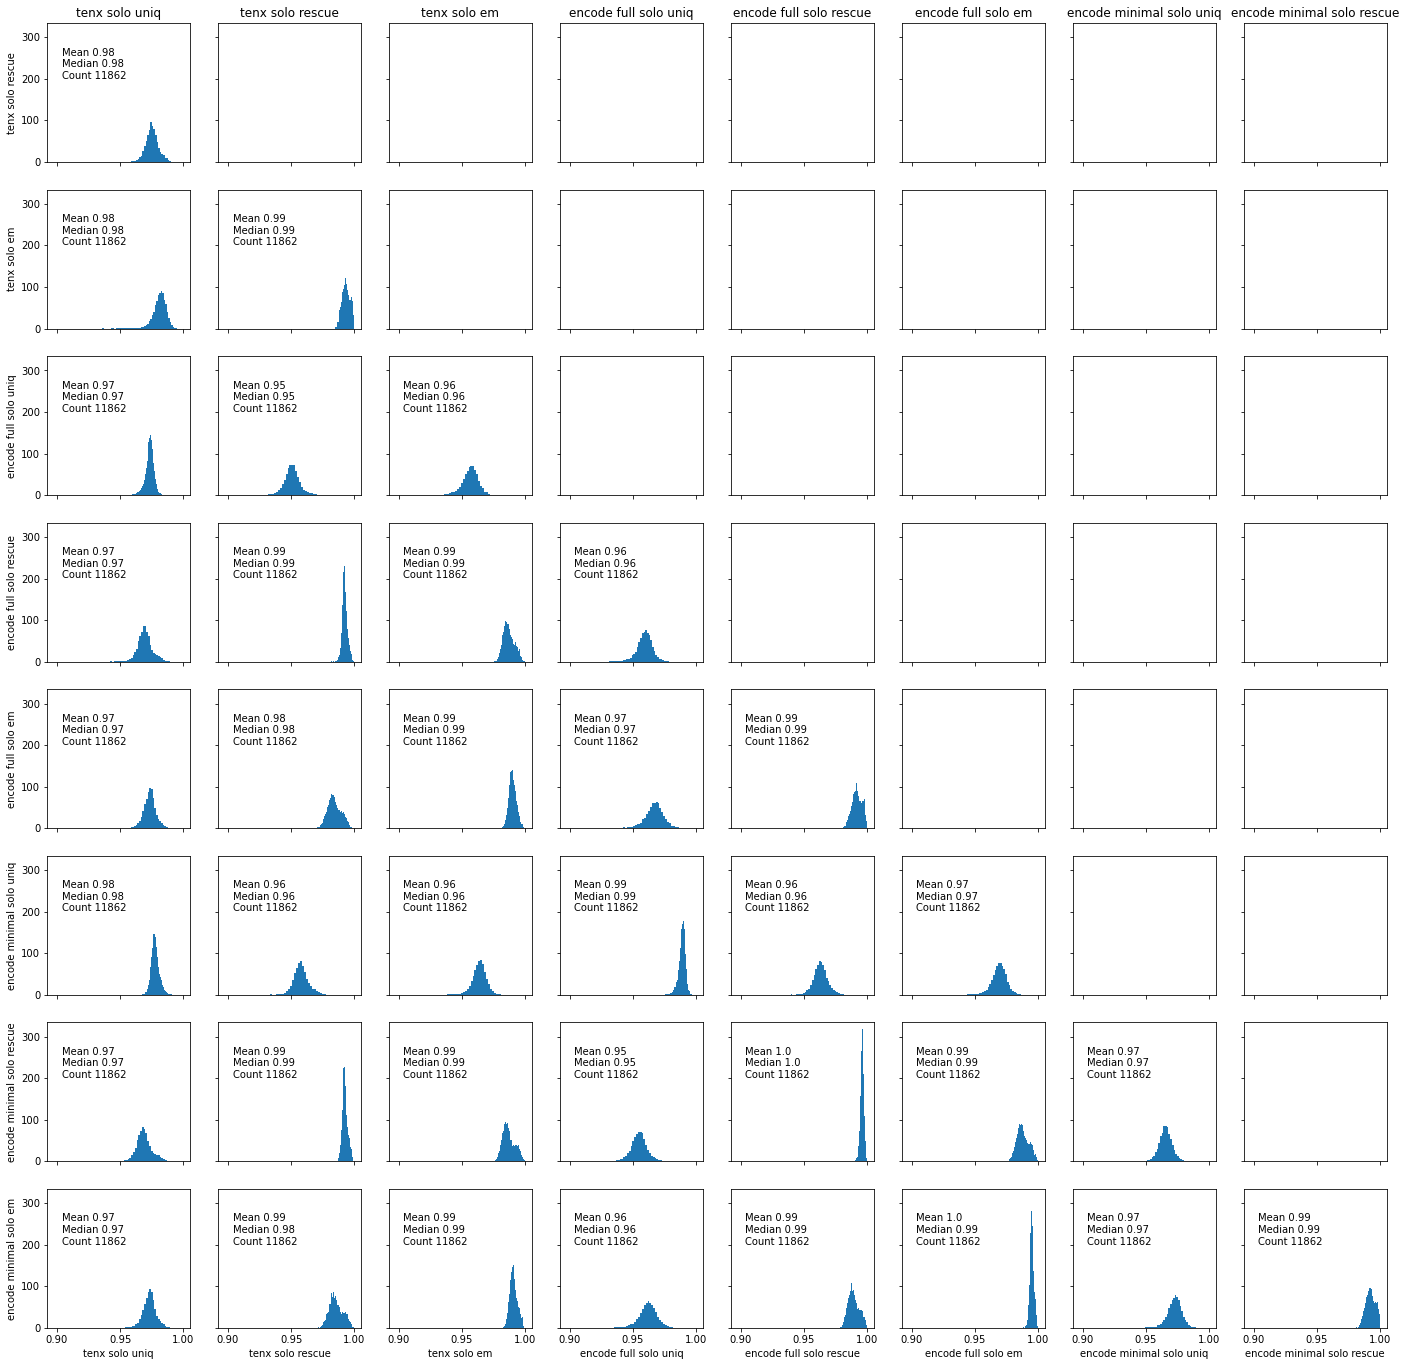

In [28]:
plot_cell_correlation_histogram(algorithm_correlations)

# Scatter plot of method genes in common over all cells

In [29]:
def plot_algorithm_sums(table, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)    
    if title is not None:
        f.suptitle(title.format(metric=metric))

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            scatter.setdefault(name_x, {})[name_y] = ax.scatter(
                numpy.asarray(table[name_x].X.sum(axis=1).T)[0], 
                numpy.asarray(table[name_y].X.sum(axis=1).T)[0],
                s=0.5
            )
            ax.set_xscale('log')
            ax.set_yscale('log')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("per algorithm sum of genes over all cells")
    #f.tight_layout()
    

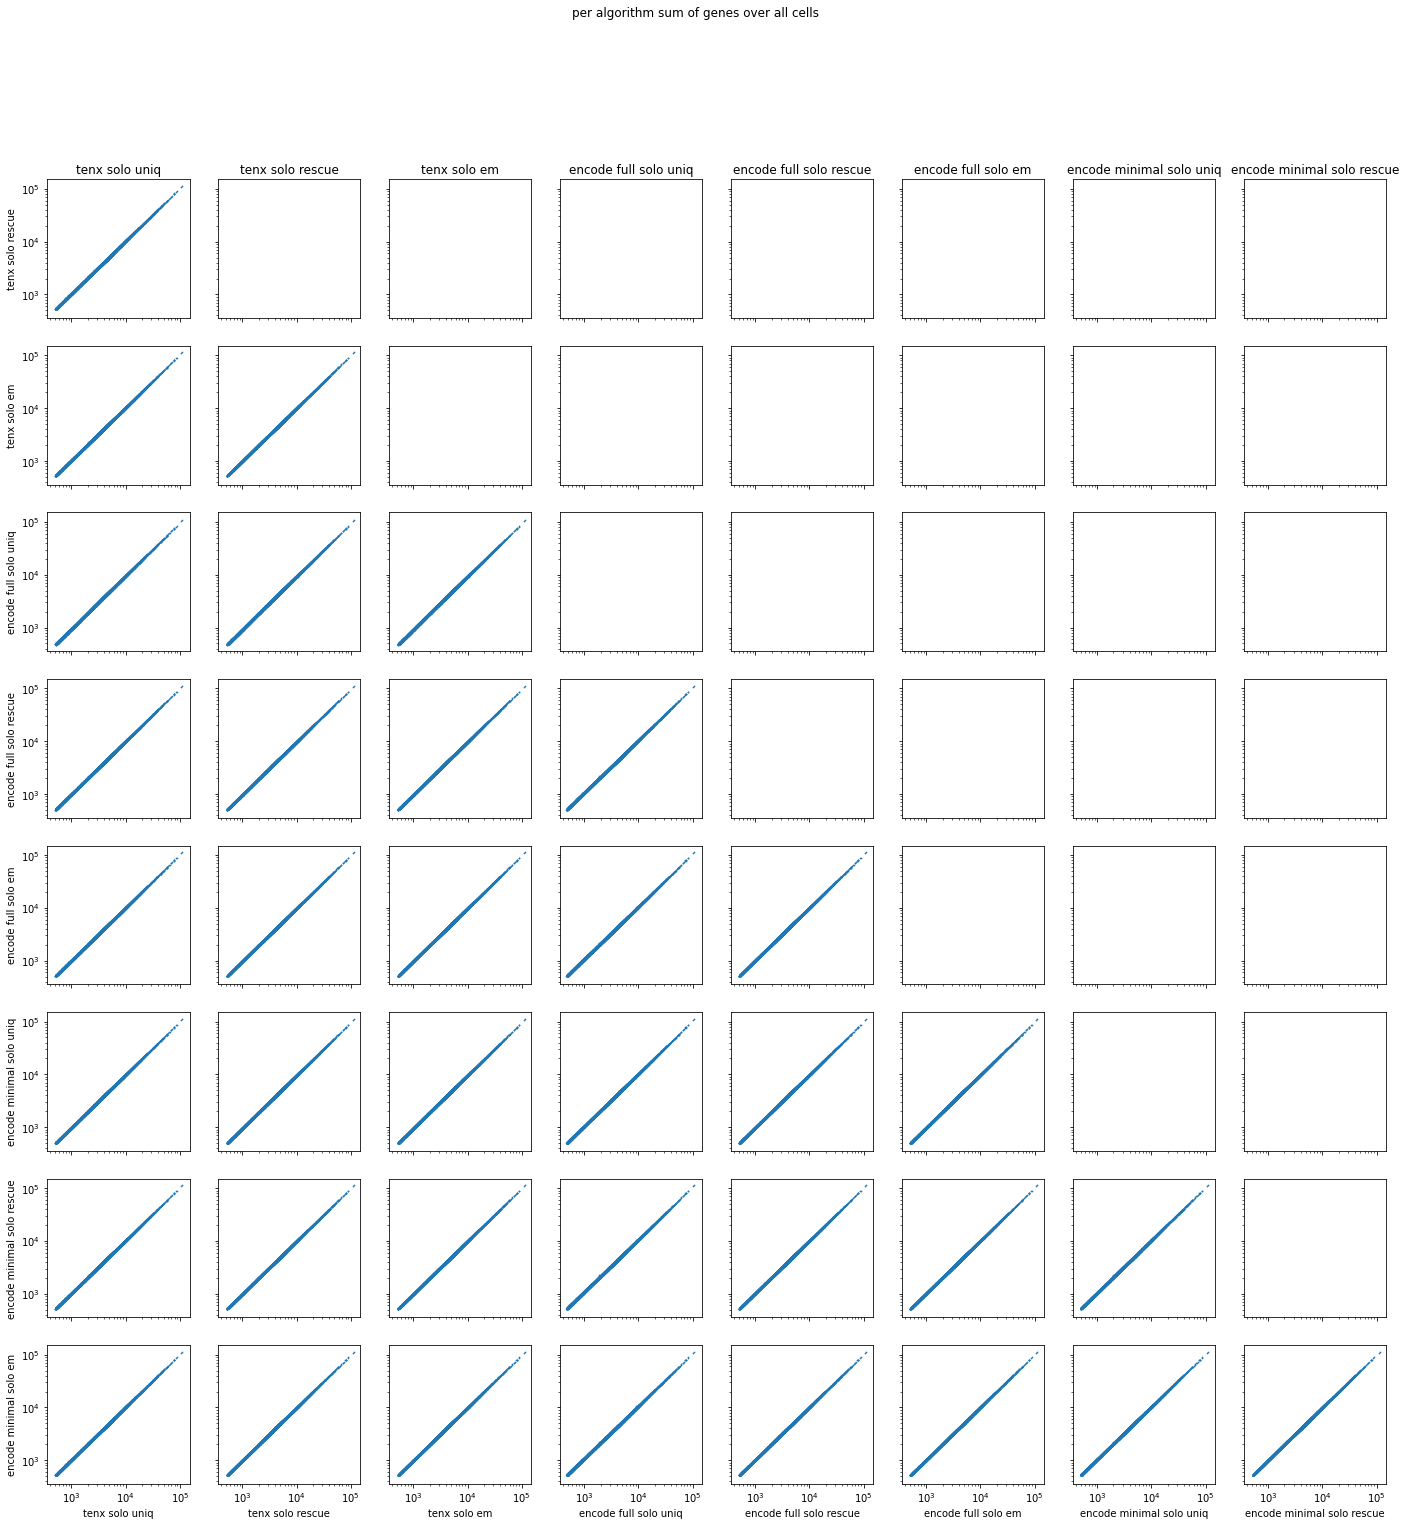

In [30]:
plot_algorithm_sums(algorithm_common)

# Scatter plots of gene expression for worst, median, and best correlated cells

In [31]:
algorithm_dense = {}
for algorithm in algorithm_common:
    algorithm_dense[algorithm] = algorithm_common[algorithm].to_df().T


In [32]:
def sc_scatter(table, correlations, name_x, name_y, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    ax.scatter(numpy.log2(table[name_x][cell_id]+0.01), numpy.log2(table[name_y][cell_id]+0.01), color=colors, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    expressed_in_x = table[name_x][cell_id] > 0
    expressed_in_y = table[name_y][cell_id] > 0
    count = table[name_x][expressed_in_x & expressed_in_y].shape[0]
    ax.set_title(f'id {cell_id}\nSpearman {spearman:0.4}\nCount: {count}')
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)

def show_scatter_extremes(dense_mat, correlations, name_x, name_y):
    scores = correlations[name_x][name_y]
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1,3, sharex=True, sharey=True)
    sc_scatter(dense_mat, correlations, name_x, name_y, worst_cell, ax=axes[0])
    sc_scatter(dense_mat, correlations, name_x, name_y, median_cell, ax=axes[1])
    sc_scatter(dense_mat, correlations, name_x, name_y, best_cell, ax=axes[2])
    return f

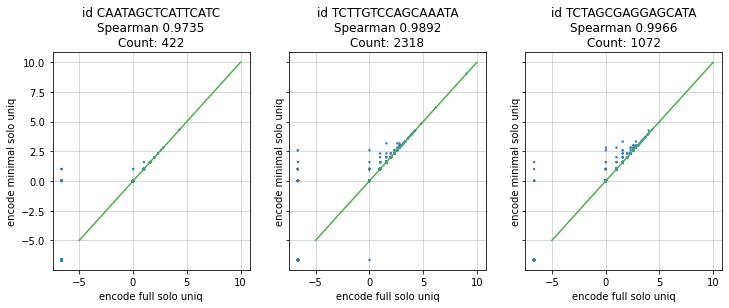

In [33]:
f = show_scatter_extremes(algorithm_dense, algorithm_correlations,'encode full solo uniq', 'encode minimal solo uniq')

<ipython-input-32-408e00a00fee>:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = pyplot.figure(figsize=(12,4))


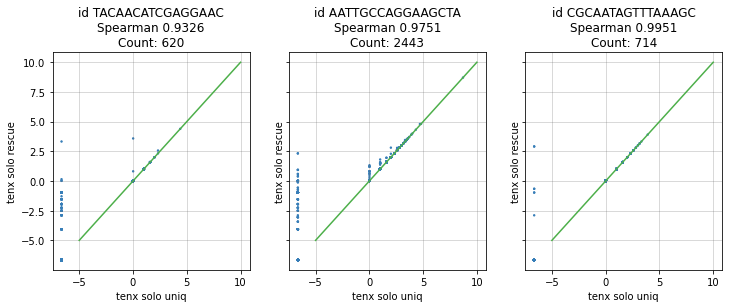

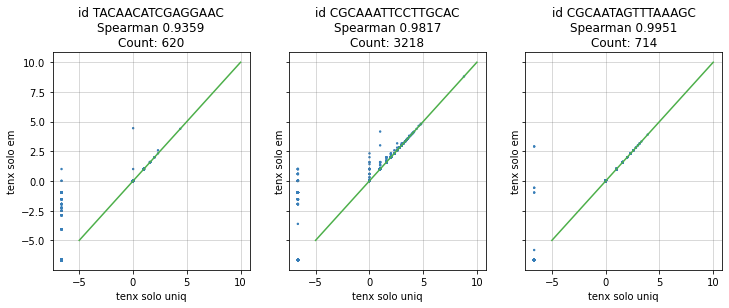

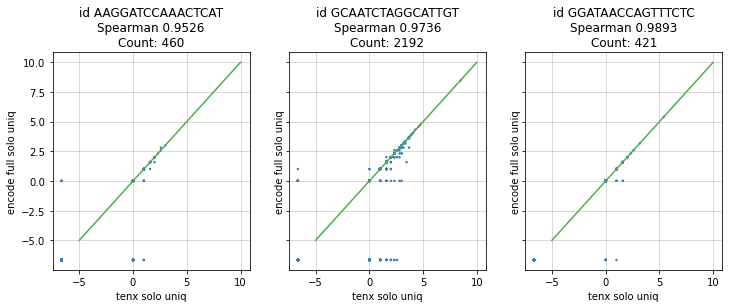

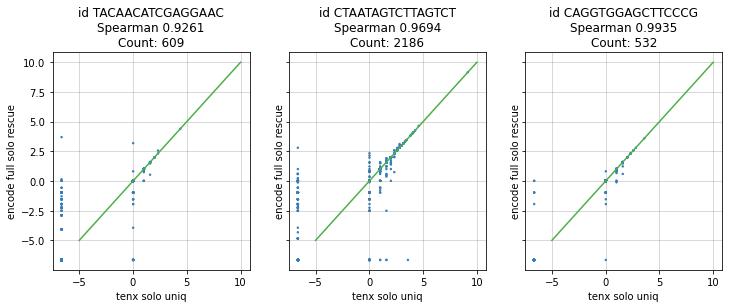

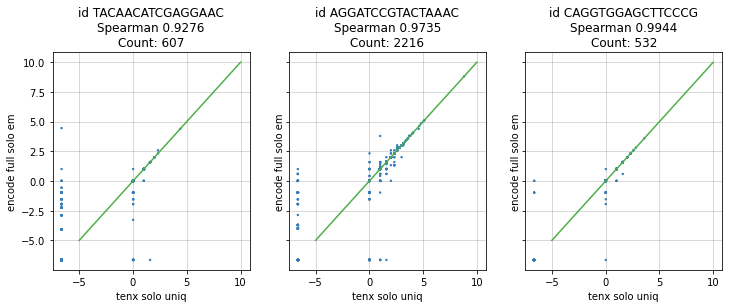

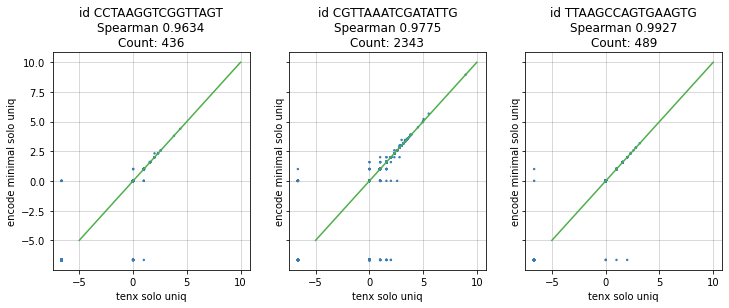

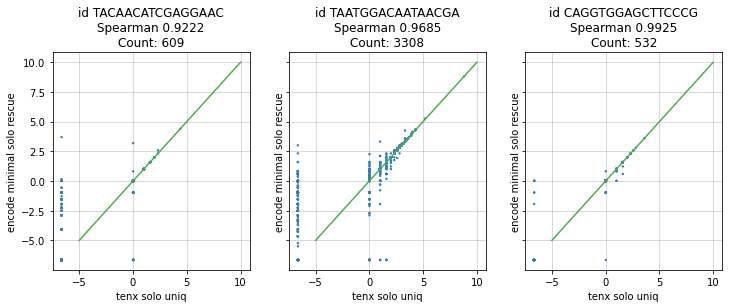

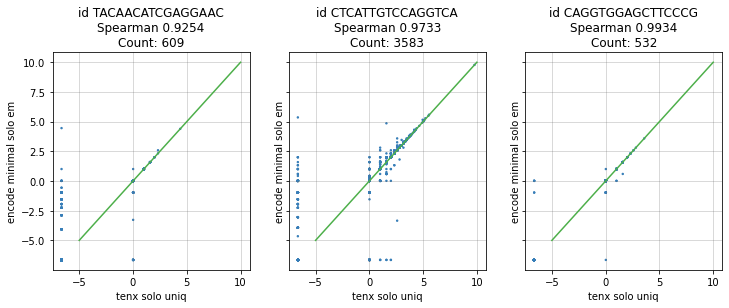

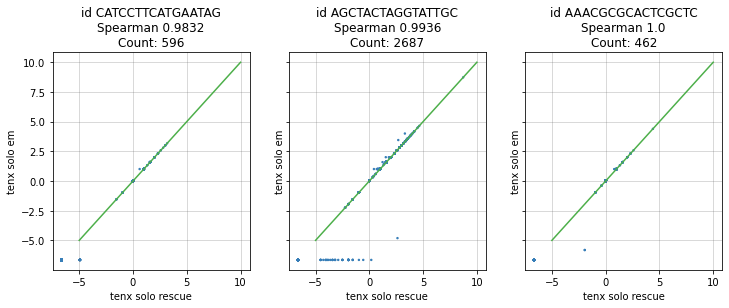

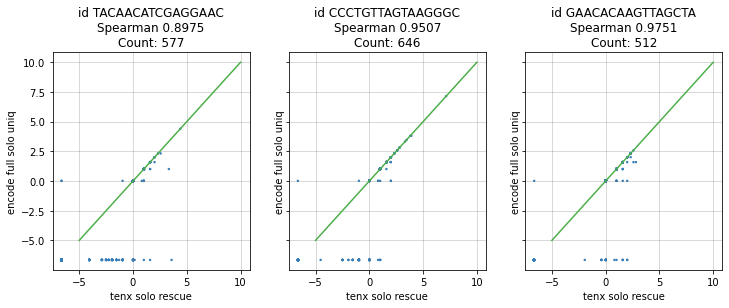

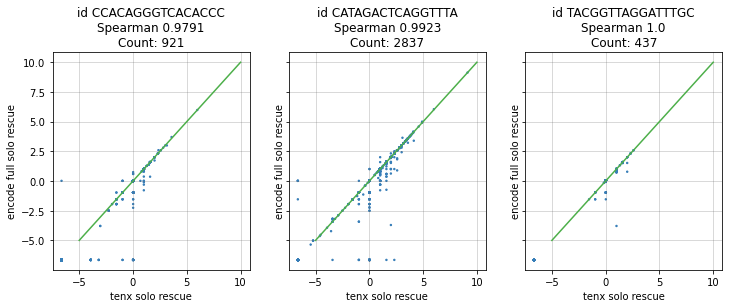

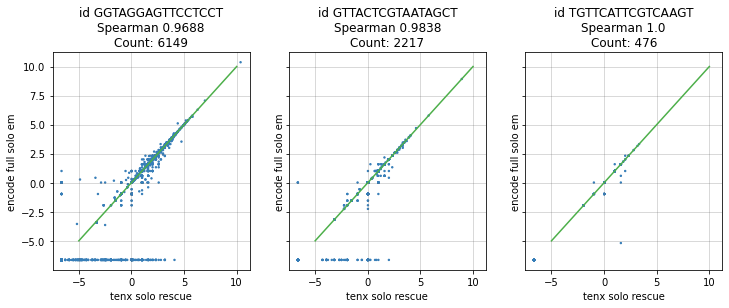

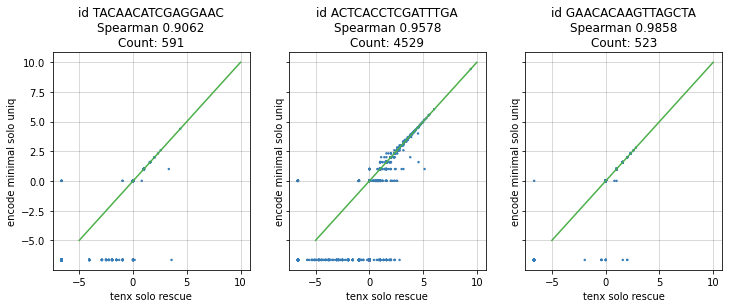

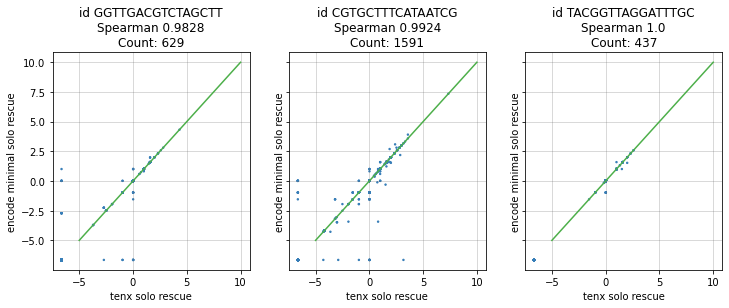

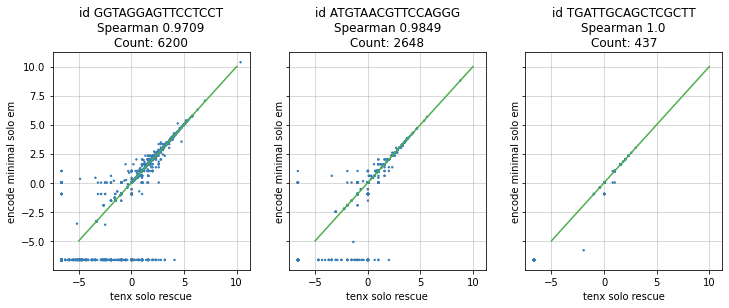

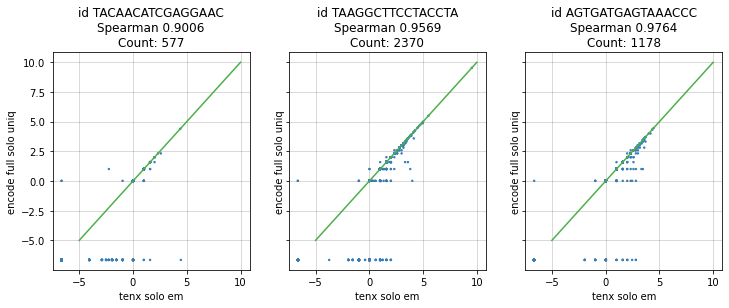

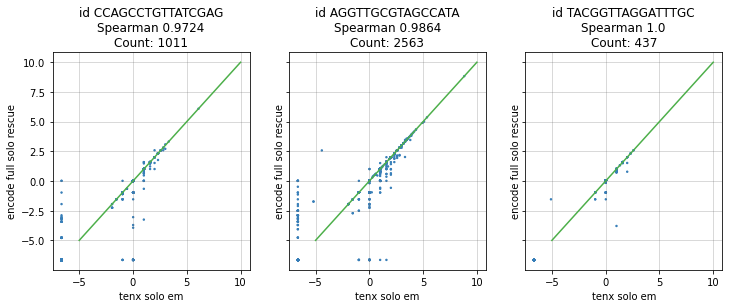

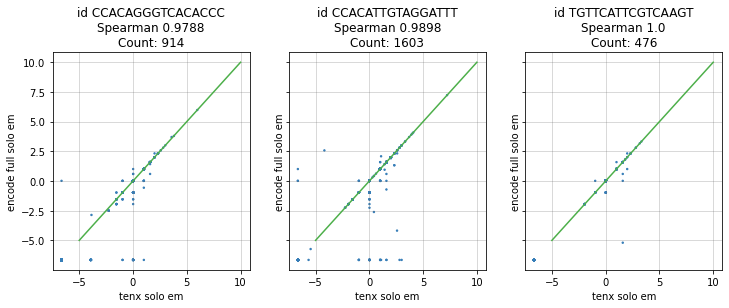

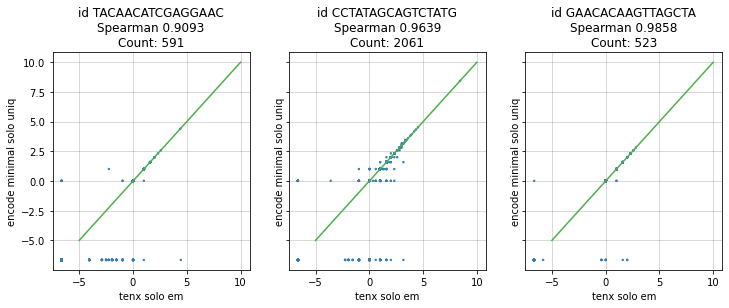

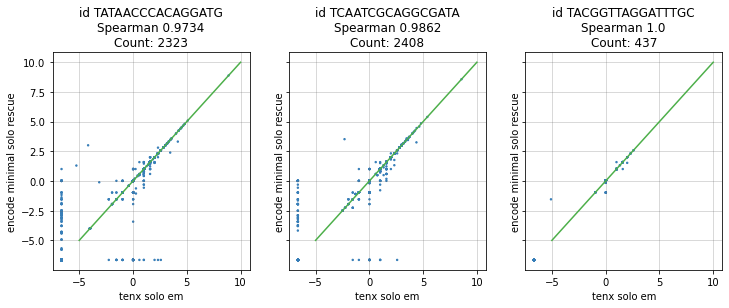

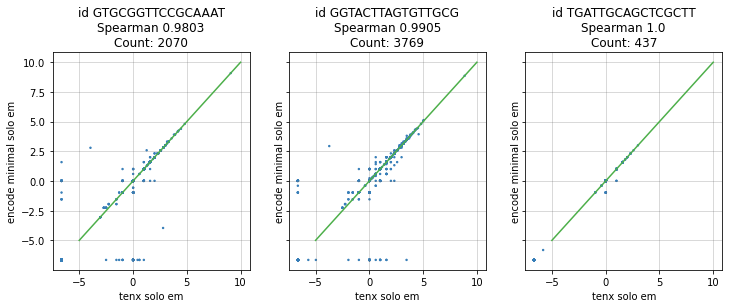

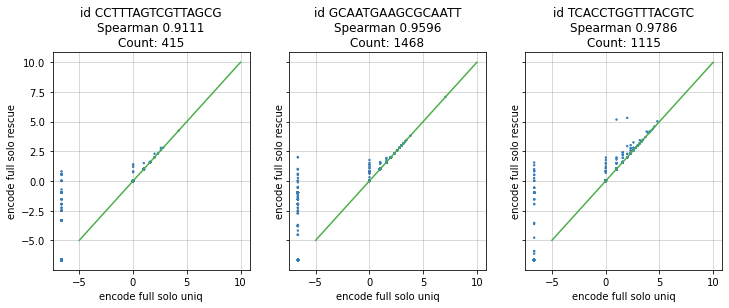

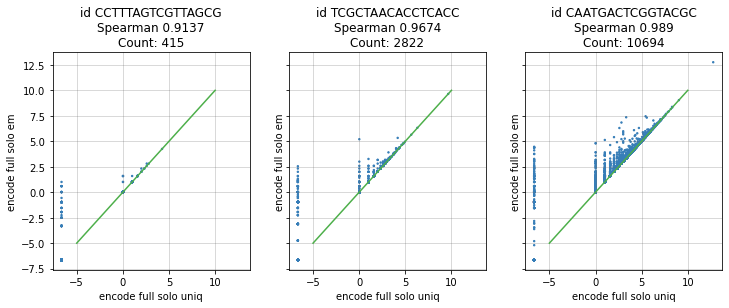

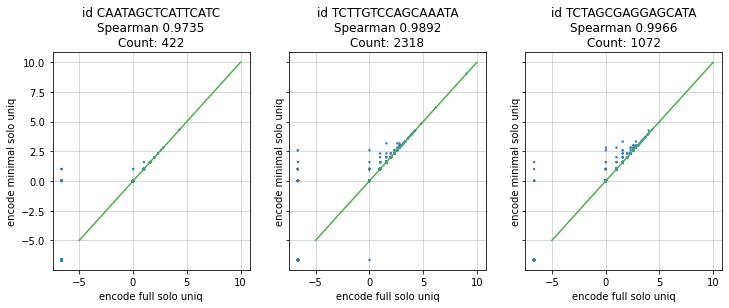

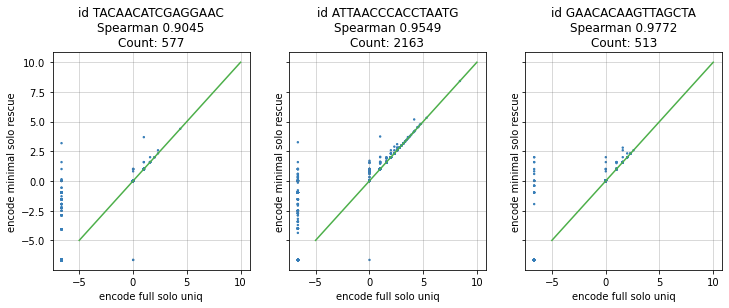

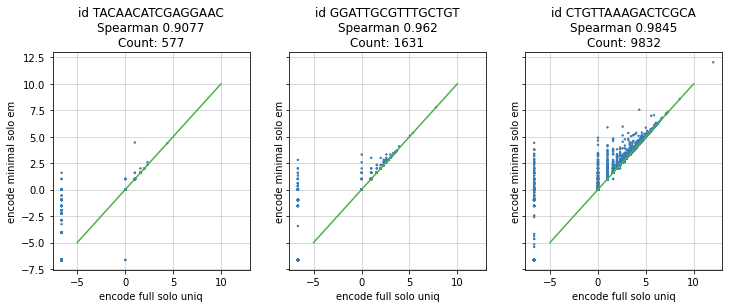

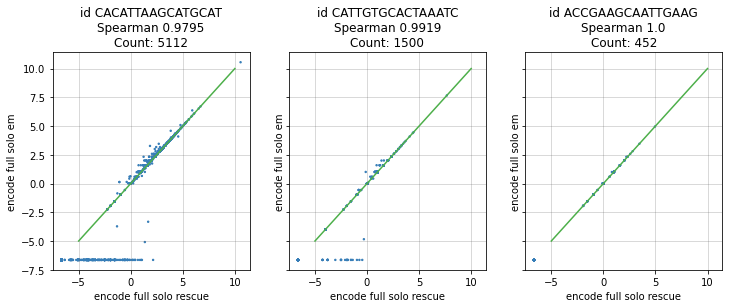

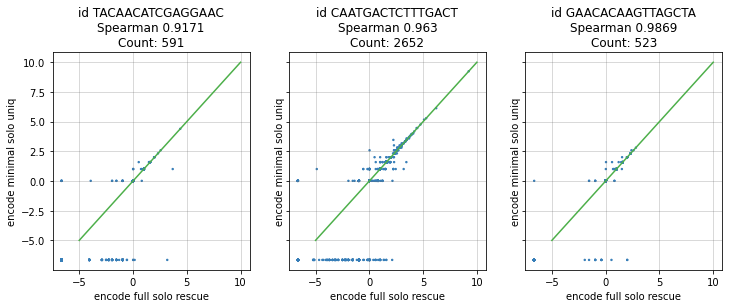

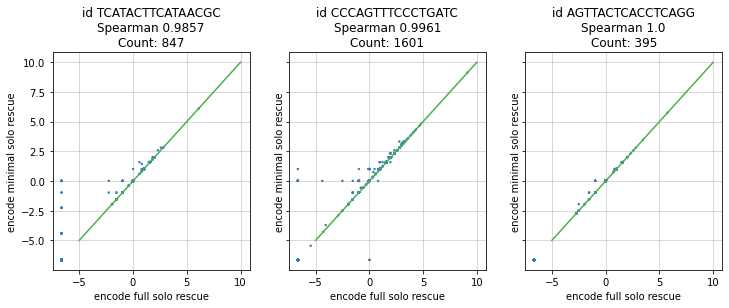

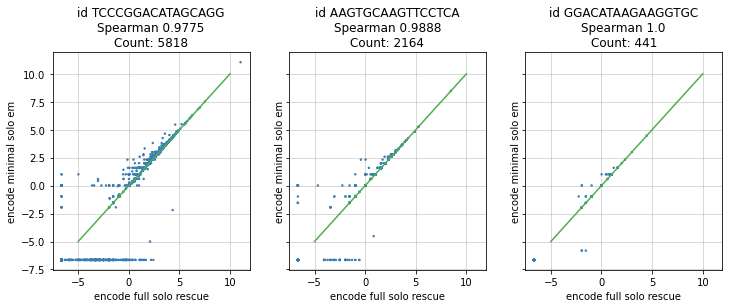

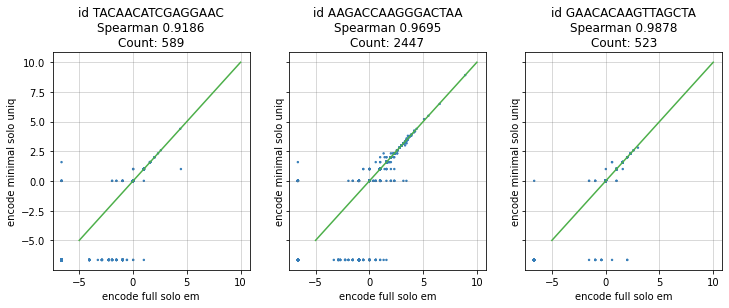

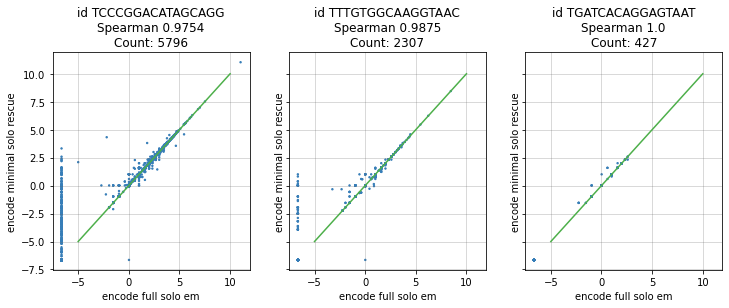

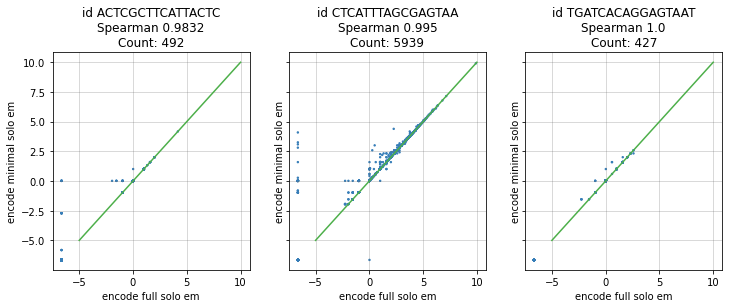

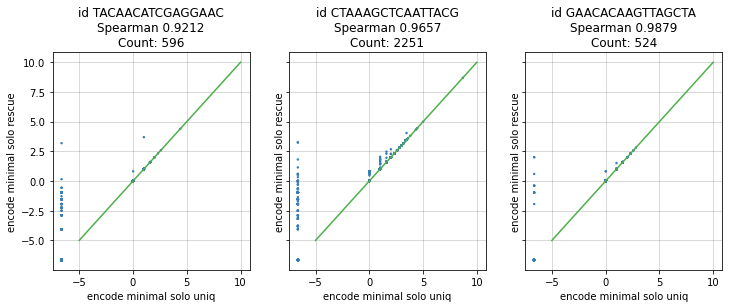

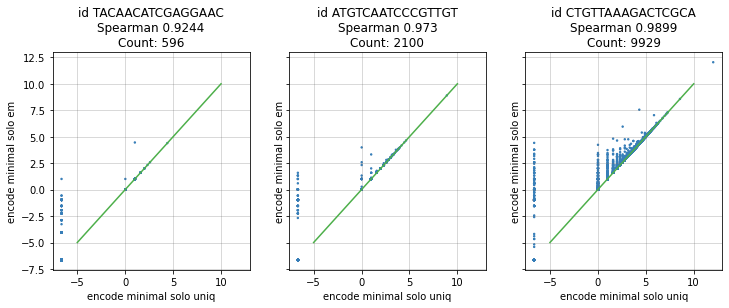

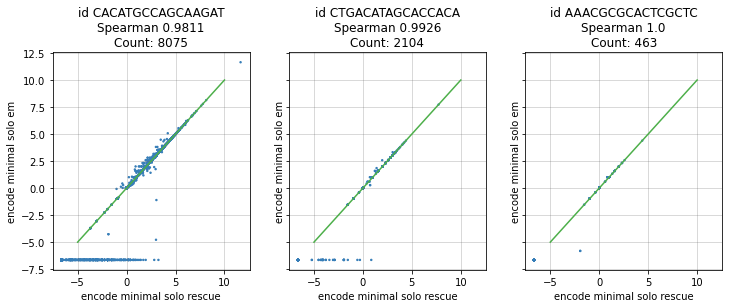

In [34]:
def plot_all_scatter_extremes(table, correlations):
    programs = list(table.keys())


    for name_x in programs:
        for name_y in programs[programs.index(name_x)+1:]:
            #print("Comparing {} {}".format(name_x, name_y))
            f = show_scatter_extremes(table, correlations, name_x, name_y)
            
            
plot_all_scatter_extremes(algorithm_dense, algorithm_correlations)

# Scatter plot of cells with the highest expression sum

In [35]:
def plot_algorithm_most_expressed(table, correlations, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)
    if title is not None:
        f.suptitle(title.format(metric=metric))


    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            max_cell = algorithm_dense[name_x].sum(axis=0).idxmax()
            scatter.setdefault(name_x, {})[name_y] = sc_scatter(table, correlations, name_x, name_y, max_cell, ax=ax)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Compare algorithms with cell with highest expression sum")
    #f.tight_layout()
    

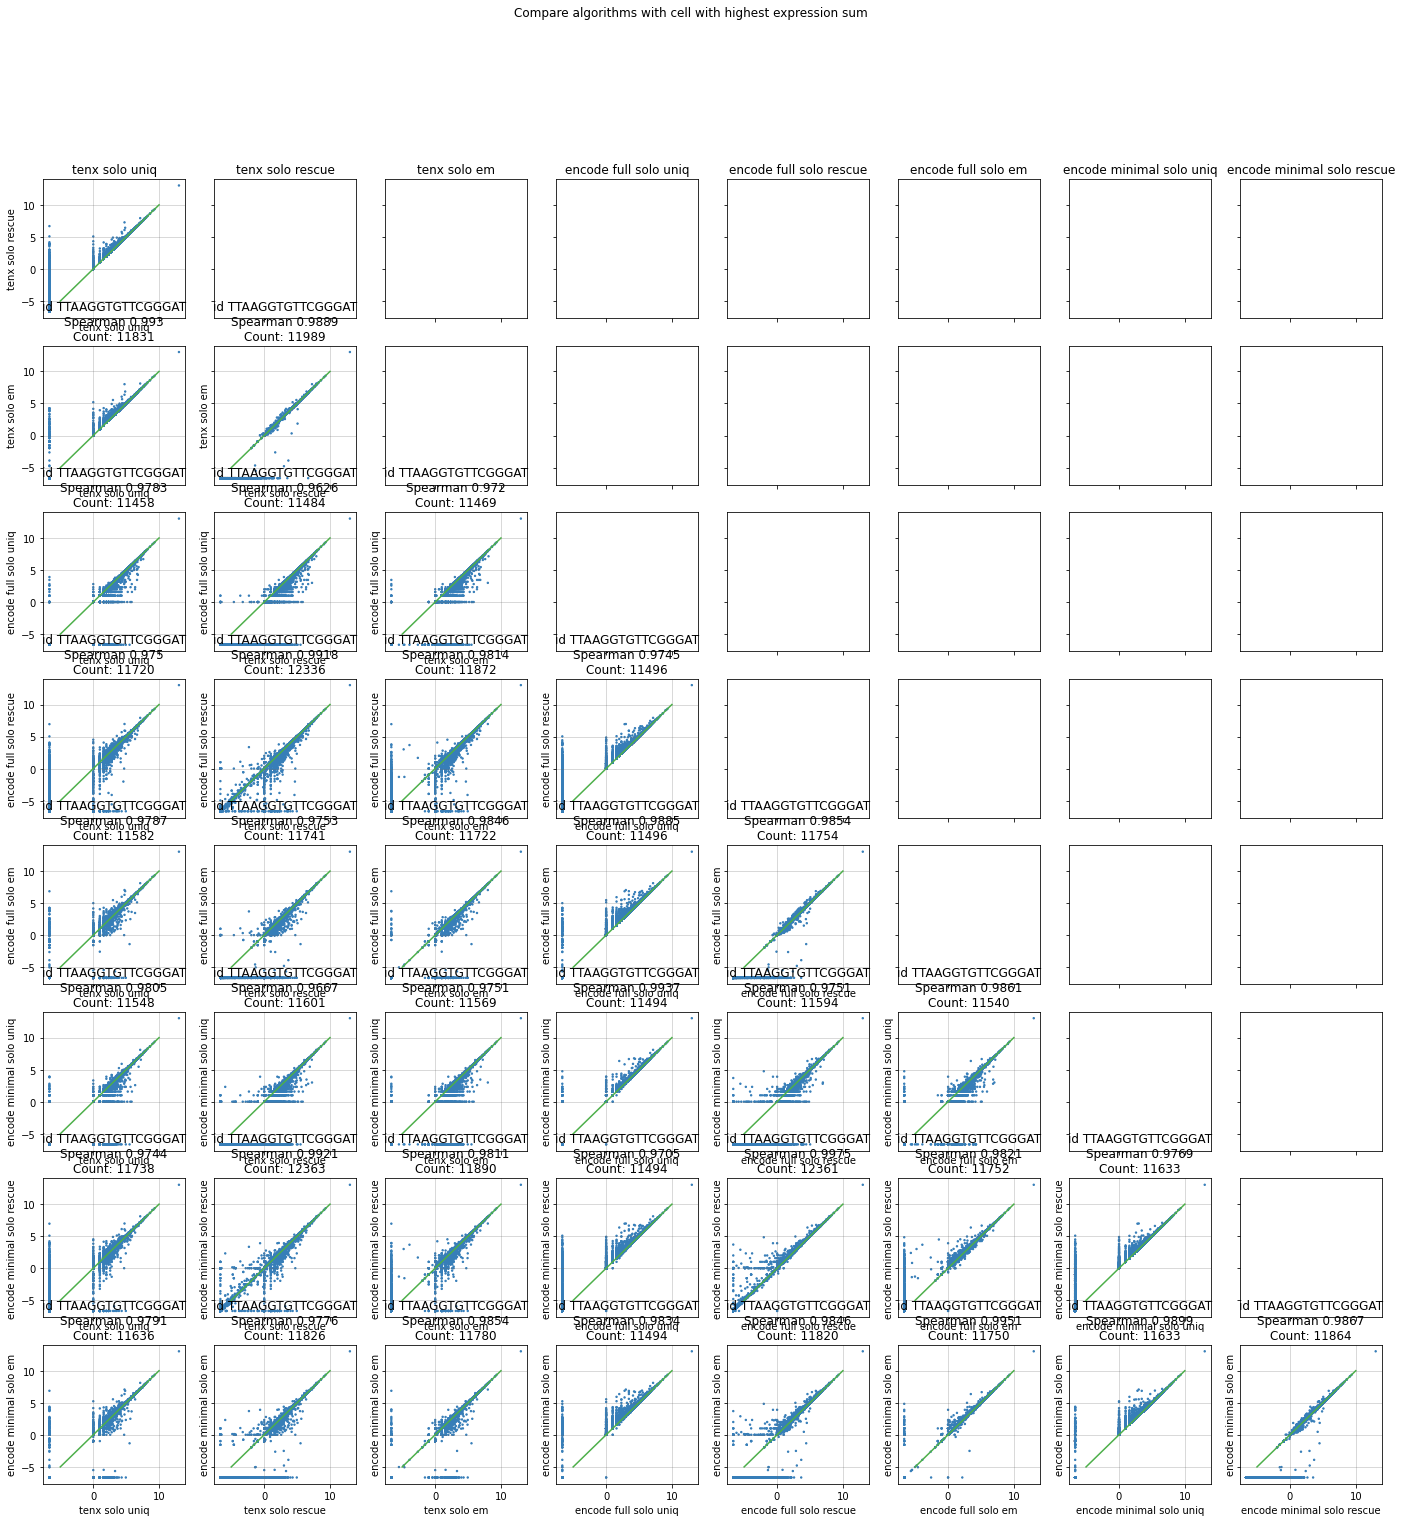

In [36]:
plot_algorithm_most_expressed(algorithm_dense, algorithm_correlations)

It seems weird that there's expression in encode minimal, but not in encode full, maybe I have the labels backward?

In [37]:
encode_minimal_uniq_sum = algorithm_dense['encode minimal solo uniq'].sum(axis=1)
encode_full_uniq_sum = algorithm_dense['encode full solo uniq'].sum(axis=1)

In [38]:
in_minimal_uniq_sum = encode_minimal_uniq_sum > 0
not_in_minimal_uniq_sum = encode_minimal_uniq_sum == 0
in_full_uniq_sum = encode_full_uniq_sum > 0
not_in_full_uniq_sum =(encode_full_uniq_sum == 0)

encode_minimal_uniq_sum[in_minimal_uniq_sum & not_in_full_uniq_sum]

ENSG00000239945.1       1.0
ENSG00000158786.4       1.0
ENSG00000142789.19     13.0
ENSG00000270103.3      32.0
ENSG00000229943.1       1.0
ENSG00000243480.7       2.0
ENSG00000196427.13      1.0
ENSG00000270066.3      34.0
ENSG00000158764.6       1.0
ENSG00000243636.1      48.0
ENSG00000270188.1       1.0
ENSG00000273006.1       2.0
ENSG00000055813.5     354.0
ENSG00000174325.5      27.0
ENSG00000227418.6       1.0
ENSG00000224884.1       5.0
ENSG00000285660.1       1.0
ENSG00000113905.4       1.0
ENSG00000205830.1       1.0
ENSG00000271958.1       5.0
ENSG00000249122.1       1.0
ENSG00000169777.6       6.0
ENSG00000250158.1     109.0
ENSG00000248753.1       8.0
ENSG00000158497.3       2.0
ENSG00000253315.1       4.0
ENSG00000250765.6       5.0
ENSG00000204421.2       1.0
ENSG00000272397.1       1.0
ENSG00000224477.5      12.0
ENSG00000283061.1       1.0
ENSG00000272328.1       6.0
ENSG00000234686.1       1.0
ENSG00000229881.1       1.0
ENSG00000232019.1     219.0
ENSG00000232301.2   

# Quick glance at genes that are expressed in just in the minimal set

In [39]:
v29_gtf.set_index('gene_id').reindex(encode_minimal_uniq_sum[in_minimal_uniq_sum & not_in_full_uniq_sum].index)

gene_name       gene_type        gene_base
ENSG00000239945.1   AL627309.3         lincRNA  ENSG00000239945
ENSG00000158786.4      PLA2G2F  protein_coding  ENSG00000158786
ENSG00000142789.19      CELA3A  protein_coding  ENSG00000142789
ENSG00000270103.3   AL360012.1         lincRNA  ENSG00000270103
ENSG00000229943.1   AC133865.1         lincRNA  ENSG00000229943
ENSG00000243480.7        AMY2A  protein_coding  ENSG00000243480
ENSG00000196427.13       NBPF4  protein_coding  ENSG00000196427
ENSG00000270066.3   AL356488.2         lincRNA  ENSG00000270066
ENSG00000158764.6        ITLN2  protein_coding  ENSG00000158764
ENSG00000243636.1   AL445493.2         lincRNA  ENSG00000243636
ENSG00000270188.1    MTRNR2L11  protein_coding  ENSG00000270188
ENSG00000273006.1   AC009229.3         lincRNA  ENSG00000273006
ENSG00000055813.5      CCDC85A  protein_coding  ENSG00000055813
ENSG00000174325.5        DIRC1  protein_coding  ENSG00000174325
ENSG00000227418.6       PCGEM1         lincRNA  ENSG00000227418
ENSG00000224884.1   AC034187.1         lincRNA  ENSG00000224884
ENSG00000285660.1   AC092958.3         lincRNA  ENSG00000285660
ENSG00000113905.4          HRG  protein_coding  ENSG00000113905
ENSG00000205830.1   AC024132.1         lincRNA  ENSG00000205830
ENSG00000271958.1   AC021860.1         lincRNA  ENSG00000271958
ENSG00000249122.1   AC105389.1         lincRNA  ENSG00000249122
ENSG00000169777.6       TAS2R1  protein_coding  ENSG00000169777
ENSG00000250158.1   AC099509.2         lincRNA  ENSG00000250158
ENSG00000248753.1   AC008406.2         lincRNA  ENSG00000248753
ENSG00000158497.3        HMHB1  protein_coding  ENSG00000158497
ENSG00000253315.1    LINC01932         lincRNA  ENSG00000253315
ENSG00000250765.6   AC138035.2         lincRNA  ENSG00000250765
ENSG00000204421.2       LY6G6C  protein_coding  ENSG00000204421
ENSG00000272397.1   AL138916.2         lincRNA  ENSG00000272397
ENSG00000224477.5   AL109933.1         lincRNA  ENSG00000224477
ENSG00000283061.1   AC215522.3         lincRNA  ENSG00000283061
ENSG00000272328.1   AC007128.2         lincRNA  ENSG00000272328
ENSG00000234686.1   AC091730.1         lincRNA  ENSG00000234686
ENSG00000229881.1   AC091685.1         lincRNA  ENSG00000229881
ENSG00000232019.1   AC074183.1         lincRNA  ENSG00000232019
ENSG00000232301.2    LNCPRESS1         lincRNA  ENSG00000232301
ENSG00000128610.11       FEZF1  protein_coding  ENSG00000128610
ENSG00000197462.3   AC003975.1         lincRNA  ENSG00000197462
ENSG00000283528.2       TCAF2C  protein_coding  ENSG00000283528
ENSG00000146910.12       CNPY1  protein_coding  ENSG00000146910
ENSG00000176269.3       OR4F21  protein_coding  ENSG00000176269
ENSG00000253960.1   AC016885.1         lincRNA  ENSG00000253960
ENSG00000213927.3        CCL27  protein_coding  ENSG00000213927
ENSG00000215112.6      FAM74A1         lincRNA  ENSG00000215112
ENSG00000185775.9    SPATA31A6  protein_coding  ENSG00000185775
ENSG00000276348.1   AL353770.3         lincRNA  ENSG00000276348
ENSG00000214929.3    SPATA31D1  protein_coding  ENSG00000214929
ENSG00000225085.1   AL162726.1         lincRNA  ENSG00000225085
ENSG00000232749.2   AL162726.4         lincRNA  ENSG00000232749
ENSG00000242375.1   AL590705.3         lincRNA  ENSG00000242375
ENSG00000136918.7        WDR38  protein_coding  ENSG00000136918
ENSG00000234244.1   AL512641.1         lincRNA  ENSG00000234244
ENSG00000264230.8      ANXA8L1  protein_coding  ENSG00000264230
ENSG00000188100.8       FAM25A  protein_coding  ENSG00000188100
ENSG00000124900.12      TRIM51  protein_coding  ENSG00000124900
ENSG00000284873.1        OOSP1  protein_coding  ENSG00000284873
ENSG00000285010.1       OOSP4A  protein_coding  ENSG00000285010
ENSG00000182450.12       KCNK4  protein_coding  ENSG00000182450
ENSG00000219435.5     CATSPERZ  protein_coding  ENSG00000219435
ENSG00000255183.1   AP000756.1         lincRNA  ENSG00000255183
ENSG00000255015.1   AP000755.1         lincRNA  ENSG00000255015
ENSG00000205057.5      CLLU1OS  protein_coding  ENSG0

# Lets try the scanpy tutorial

tenx solo uniq first phase QC


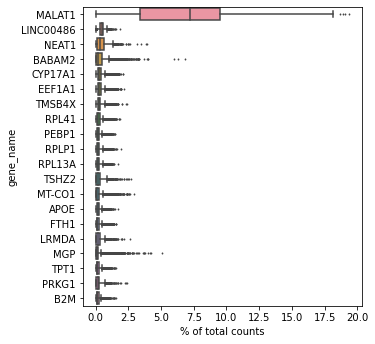

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

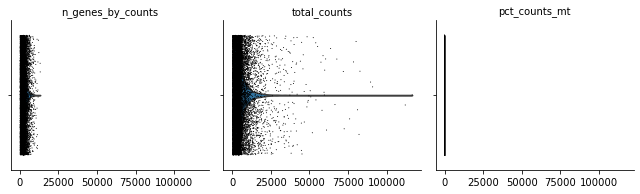

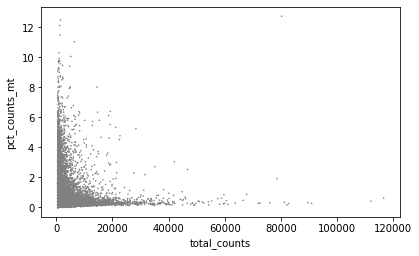

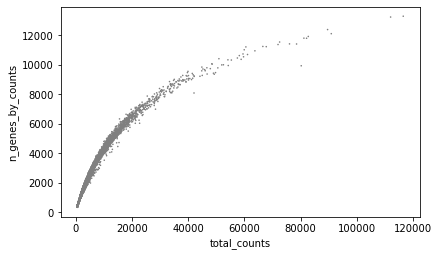

tenx solo rescue first phase QC


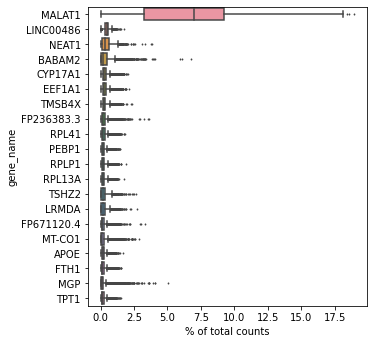

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

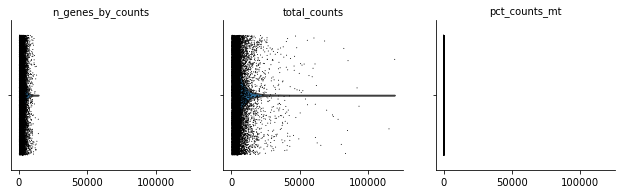

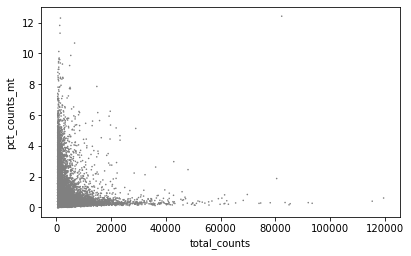

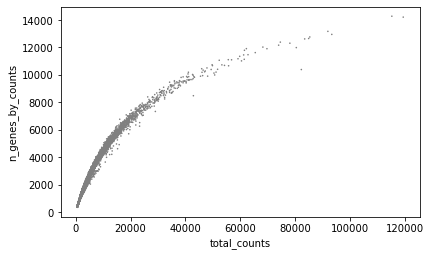

tenx solo em first phase QC


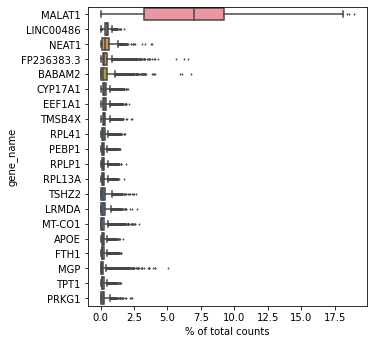

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

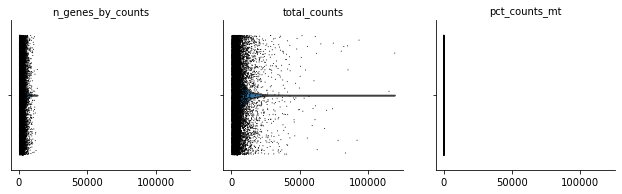

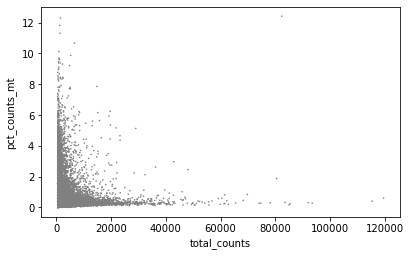

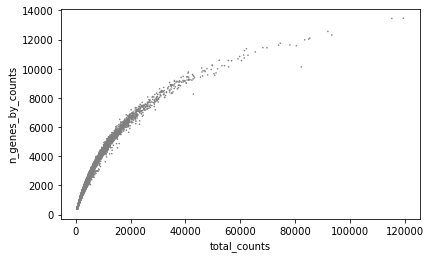

encode full solo uniq first phase QC


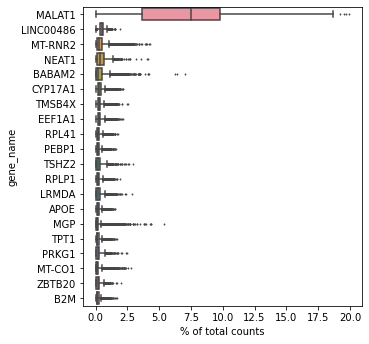

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

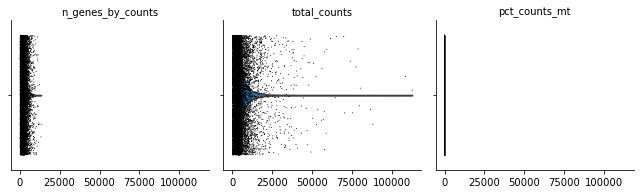

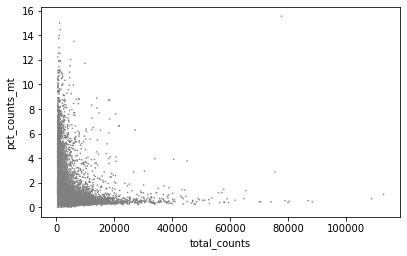

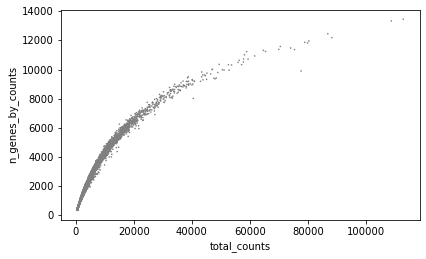

encode full solo rescue first phase QC


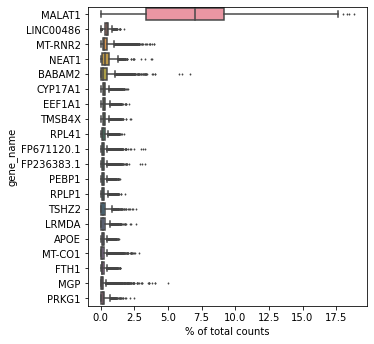

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

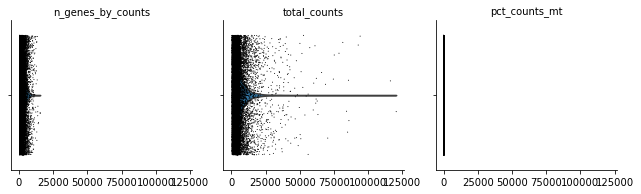

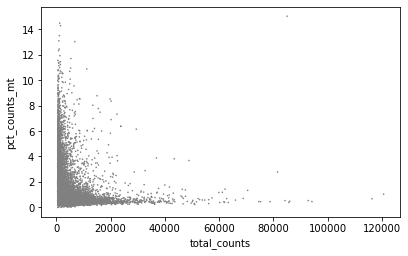

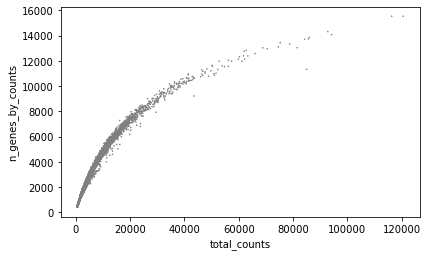

encode full solo em first phase QC


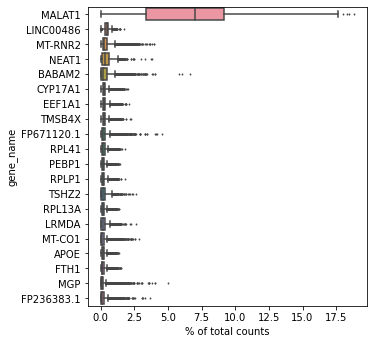

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

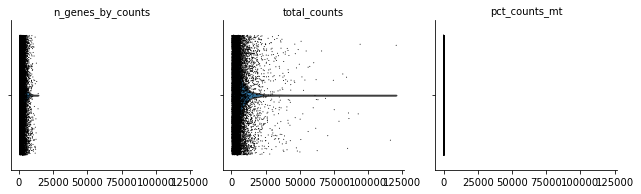

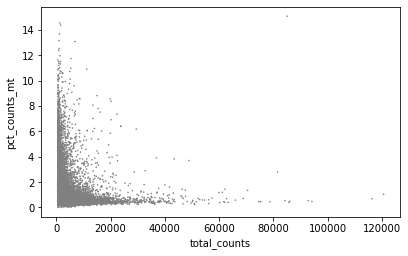

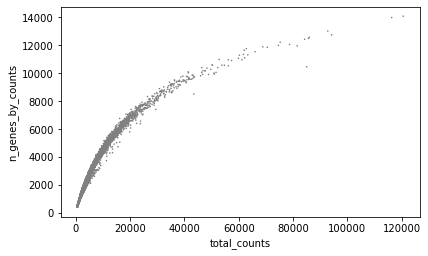

encode minimal solo uniq first phase QC


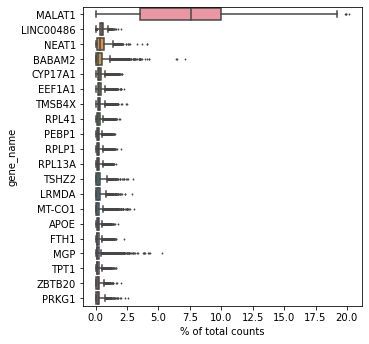

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

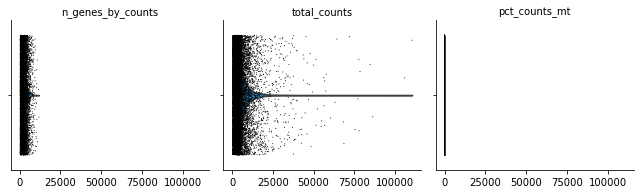

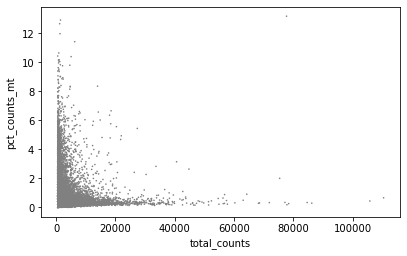

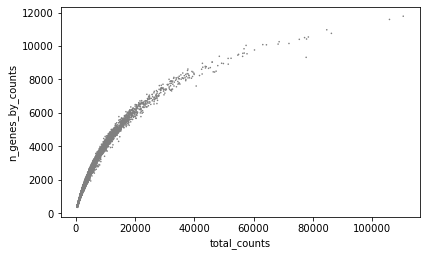

encode minimal solo rescue first phase QC


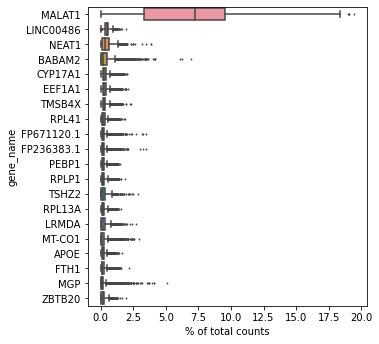

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

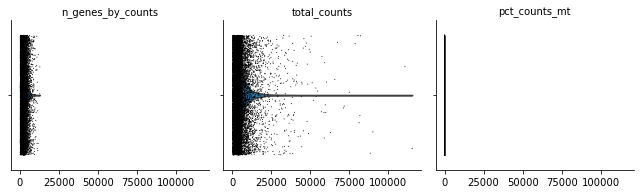

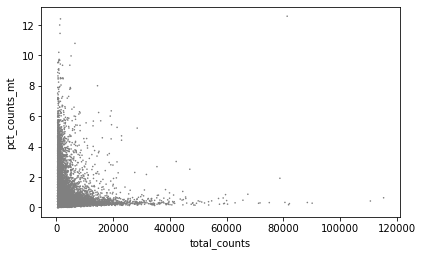

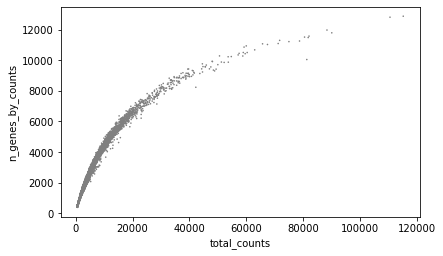

encode minimal solo em first phase QC


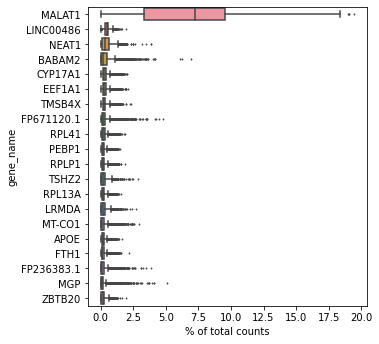

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

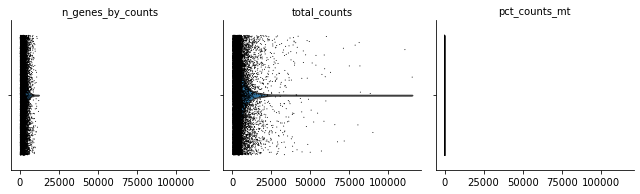

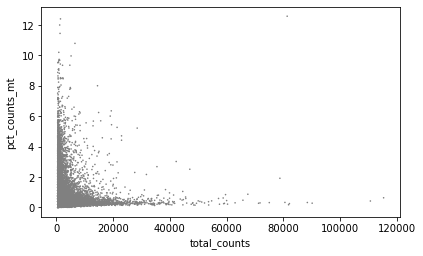

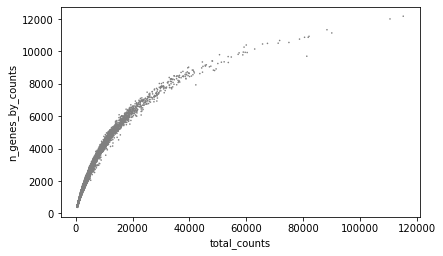

In [40]:
for algorithm in algorithm_filtered:
    print("{algorithm} first phase QC".format(algorithm=algorithm))    
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var['gene_name'] = [v32m_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v32m_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
    else:
        algorithm_filtered[algorithm].var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        
    scanpy.pl.highest_expr_genes(algorithm_filtered[algorithm], n_top=20, gene_symbols='gene_name')
    scanpy.pp.filter_cells(algorithm_filtered[algorithm], min_genes=200)
    scanpy.pp.filter_genes(algorithm_filtered[algorithm], min_cells=3)
    algorithm_filtered[algorithm].var['mt'] = algorithm_filtered[algorithm].var['gene_name'].str.startswith("MT-")
    scanpy.pp.calculate_qc_metrics(algorithm_filtered[algorithm], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    scanpy.pl.violin(
        algorithm_filtered[algorithm],
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4, multi_panel=True)
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='pct_counts_mt')
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='n_genes_by_counts')        

tenx solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


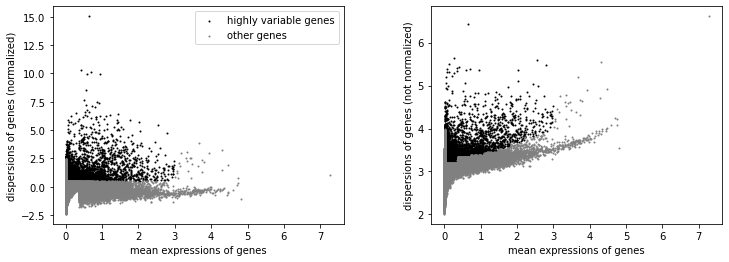

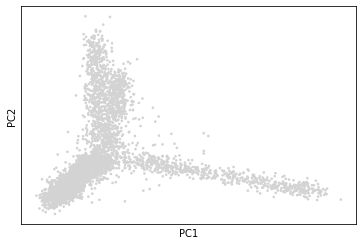

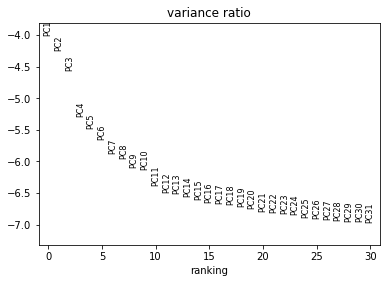

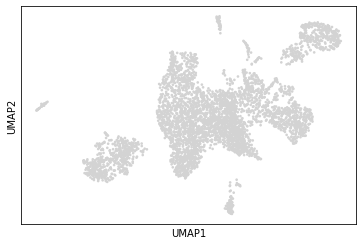

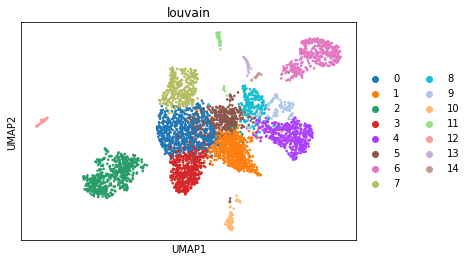

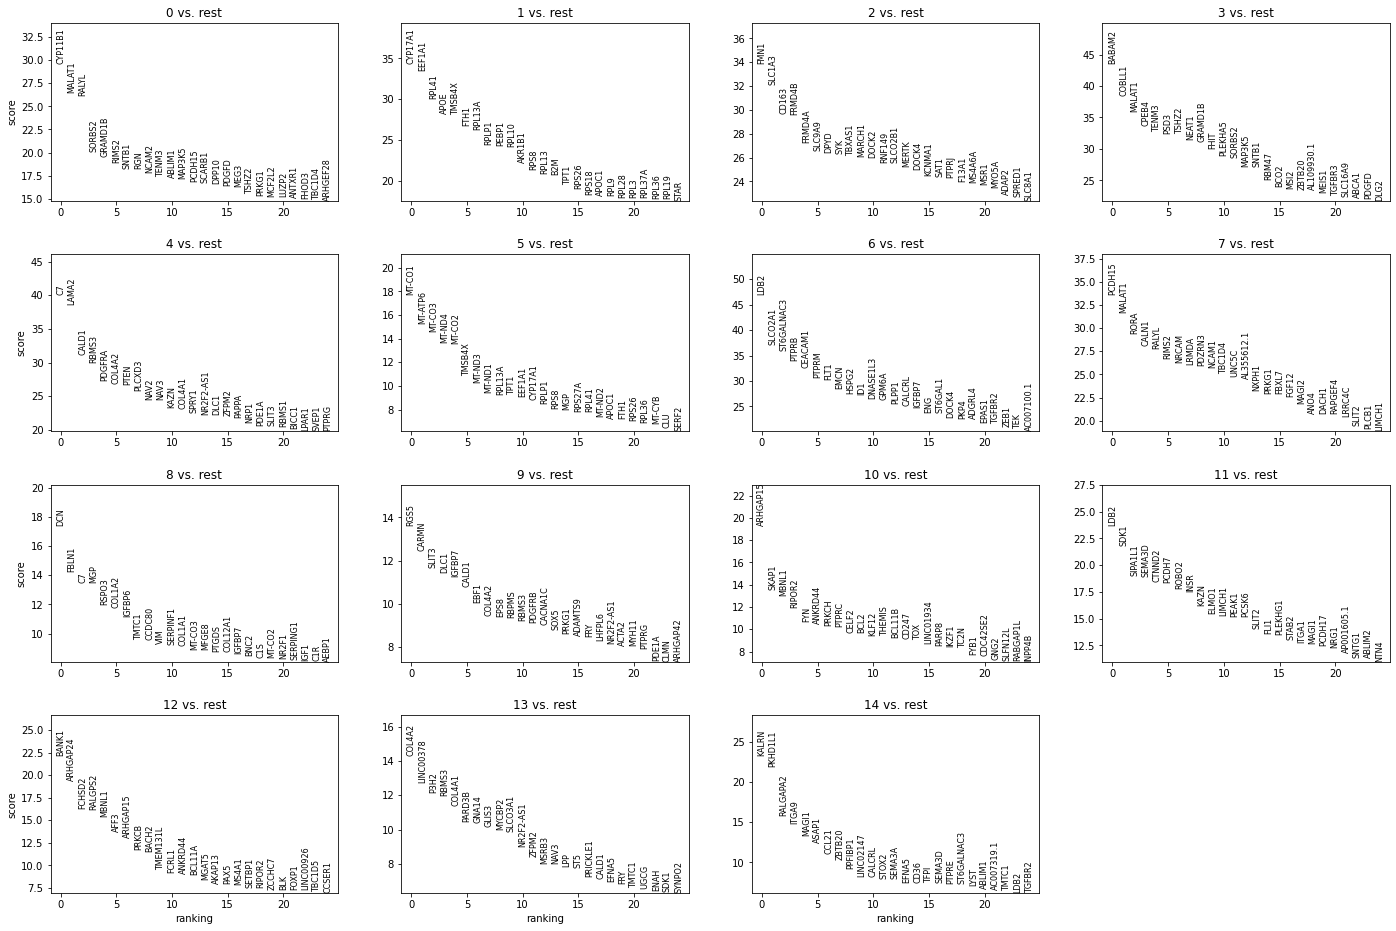

top gene names
         0        1       2       3       4        5           6       7  \
0  CYP11B1  CYP17A1    FMN1  BABAM2      C7   MT-CO1        LDB2  PCDH15   
1   MALAT1   EEF1A1  SLC1A3  COBLL1   LAMA2  MT-ATP6     SLCO2A1  MALAT1   
2    RALYL    RPL41   CD163  MALAT1   CALD1   MT-CO3  ST6GALNAC3    RORA   
3   SORBS2     APOE  FRMD4B   CPEB4   RBMS3   MT-ND4       PTPRB   CALN1   
4  GRAMD1B   TMSB4X  FRMD4A   TENM3  PDGFRA   MT-CO2     CEACAM1   RALYL   

       8       9        10       11        12         13        14  
0    DCN    RGS5  ARHGAP15     LDB2     BANK1     COL4A2     KALRN  
1  FBLN1   CARMN     SKAP1     SDK1  ARHGAP24  LINC00378   PKHD1L1  
2     C7   SLIT3     MBNL1  SIPA1L1    FCHSD2       P3H2  RALGAPA2  
3    MGP    DLC1    RIPOR2   SEMA3D   RALGPS2      RBMS3     ITGA9  
4  RSPO3  IGFBP7       FYN   CTNND2     MBNL1     COL4A1     MAGI1  
tenx solo rescue clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


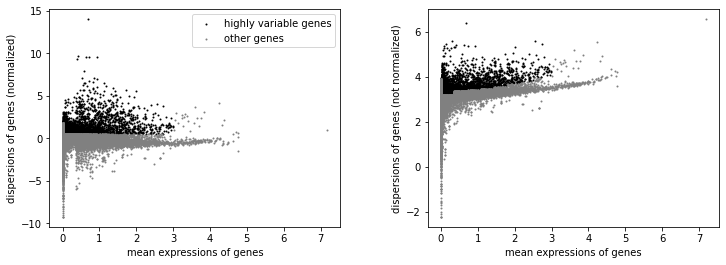

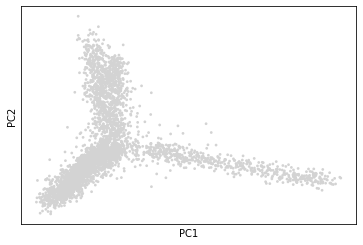

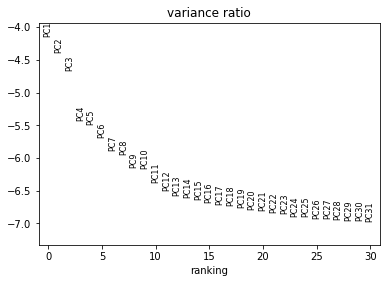

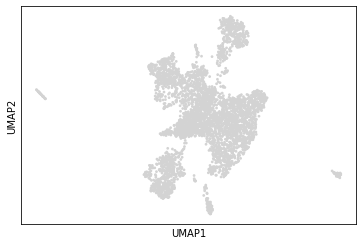

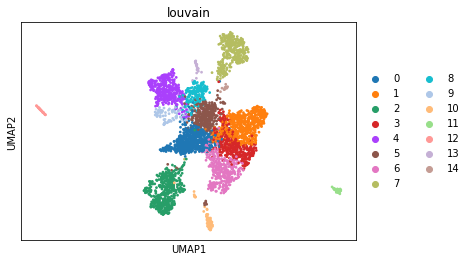

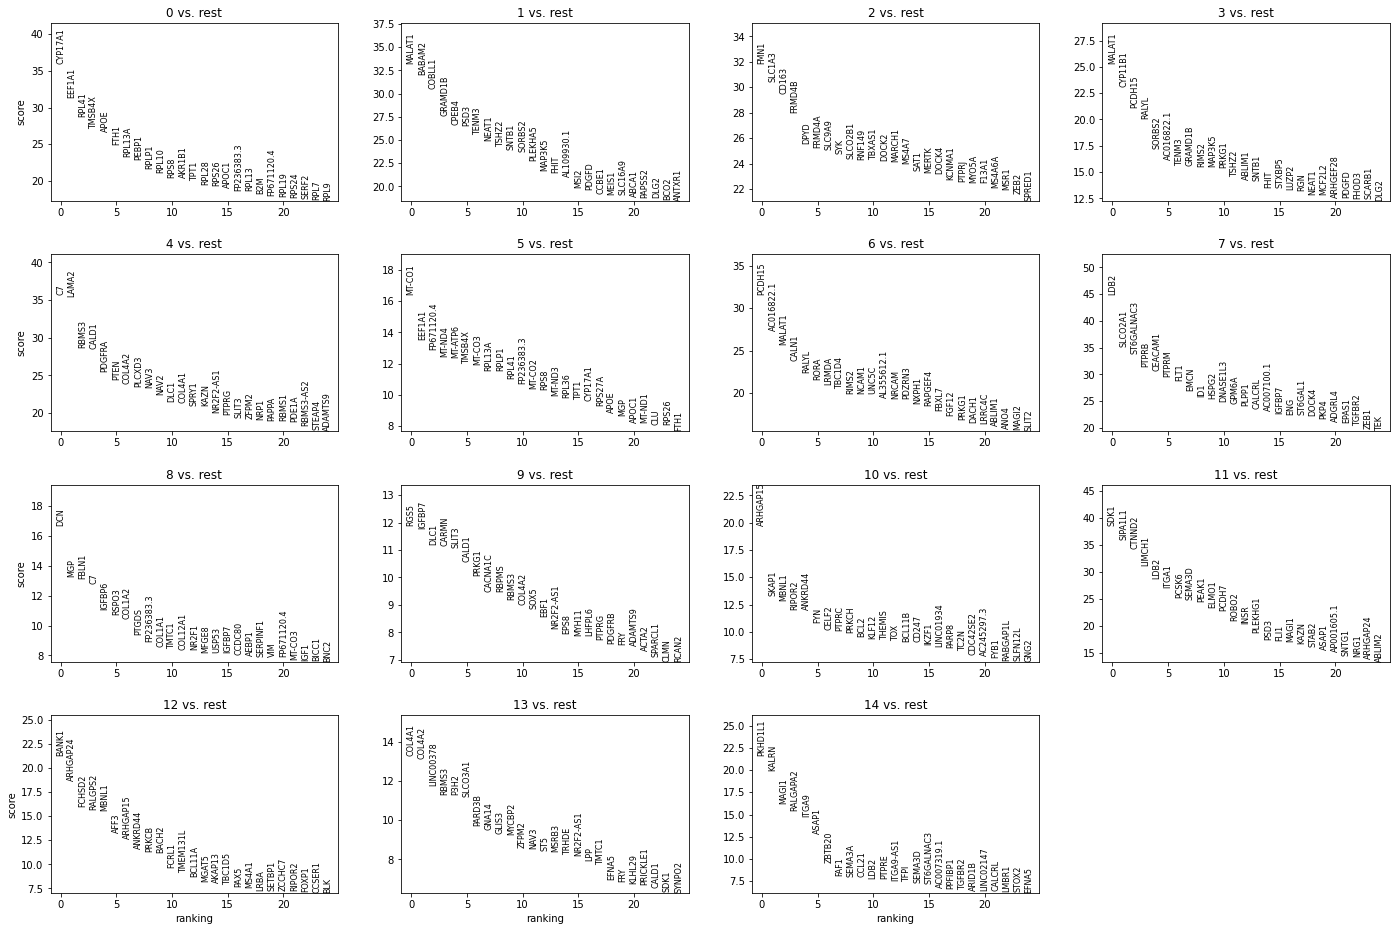

top gene names
         0        1       2        3       4           5           6  \
0  CYP17A1   MALAT1    FMN1   MALAT1      C7      MT-CO1      PCDH15   
1   EEF1A1   BABAM2  SLC1A3  CYP11B1   LAMA2      EEF1A1  AC016822.1   
2    RPL41   COBLL1   CD163   PCDH15   RBMS3  FP671120.1      MALAT1   
3   TMSB4X  GRAMD1B  FRMD4B    RALYL   CALD1      MT-ND4       CALN1   
4     APOE    CPEB4    DPYD   SORBS2  PDGFRA     MT-ATP6       RALYL   

            7       8       9        10       11        12         13  \
0        LDB2     DCN    RGS5  ARHGAP15     SDK1     BANK1     COL4A1   
1     SLCO2A1     MGP  IGFBP7     SKAP1  SIPA1L1  ARHGAP24     COL4A2   
2  ST6GALNAC3   FBLN1    DLC1     MBNL1   CTNND2    FCHSD2  LINC00378   
3       PTPRB      C7   CARMN    RIPOR2   LIMCH1   RALGPS2      RBMS3   
4     CEACAM1  IGFBP6   SLIT3   ANKRD44     LDB2     MBNL1       P3H2   

         14  
0   PKHD1L1  
1     KALRN  
2     MAGI1  
3  RALGAPA2  
4     ITGA9  
tenx solo em clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


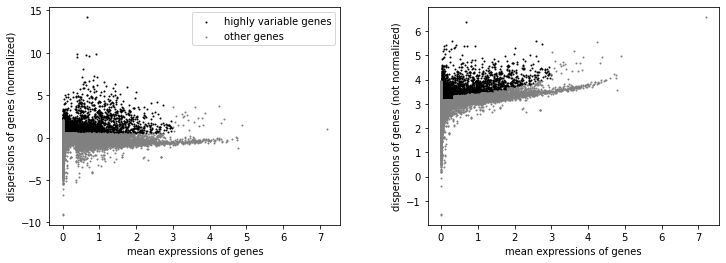

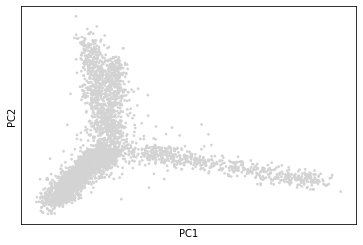

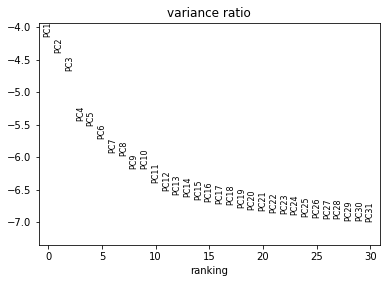

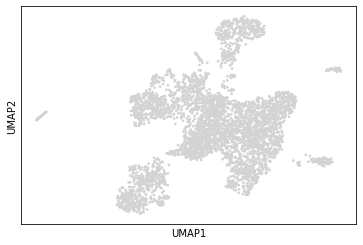

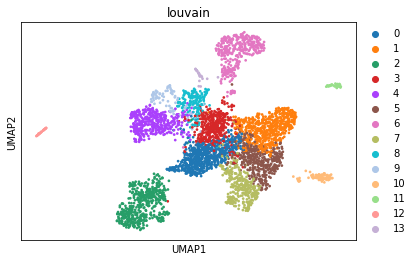

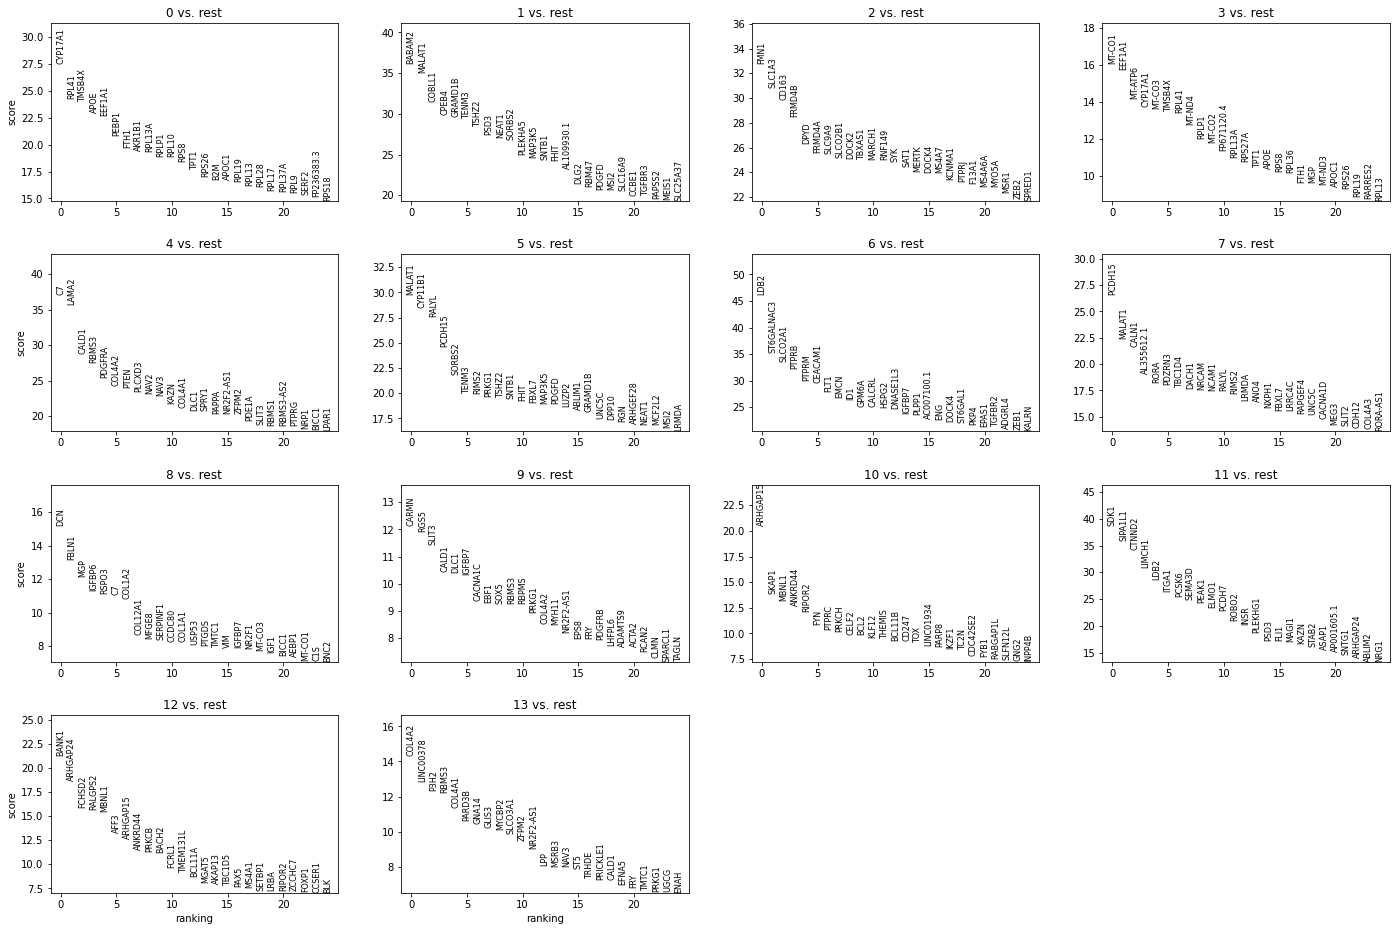

top gene names
         0        1       2        3       4        5           6           7  \
0  CYP17A1   BABAM2    FMN1   MT-CO1      C7   MALAT1        LDB2      PCDH15   
1    RPL41   MALAT1  SLC1A3   EEF1A1   LAMA2  CYP11B1  ST6GALNAC3      MALAT1   
2   TMSB4X   COBLL1   CD163  MT-ATP6   CALD1    RALYL     SLCO2A1       CALN1   
3     APOE    CPEB4  FRMD4B  CYP17A1   RBMS3   PCDH15       PTPRB  AL590426.2   
4   EEF1A1  GRAMD1B    DPYD   MT-CO3  PDGFRA   SORBS2       PTPRM        RORA   

        8      9        10       11        12         13  
0     DCN  CARMN  ARHGAP15     SDK1     BANK1     COL4A2  
1   FBLN1   RGS5     SKAP1  SIPA1L1  ARHGAP24  LINC00378  
2     MGP  SLIT3     MBNL1   CTNND2    FCHSD2       P3H2  
3  IGFBP6  CALD1   ANKRD44   LIMCH1   RALGPS2      RBMS3  
4   RSPO3   DLC1    RIPOR2     LDB2     MBNL1     COL4A1  
encode full solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


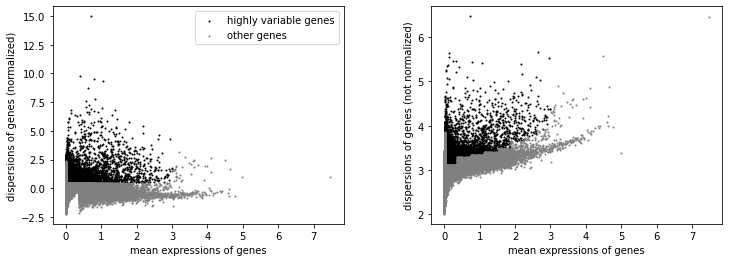

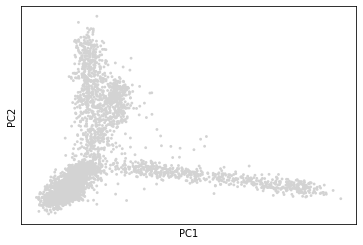

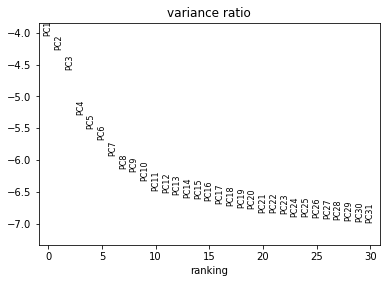

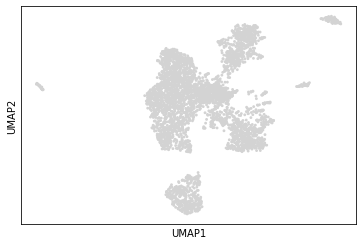

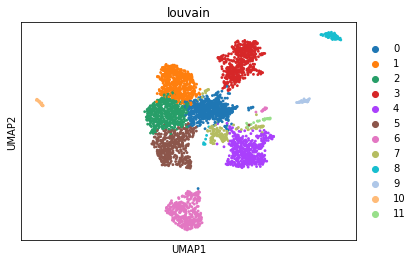

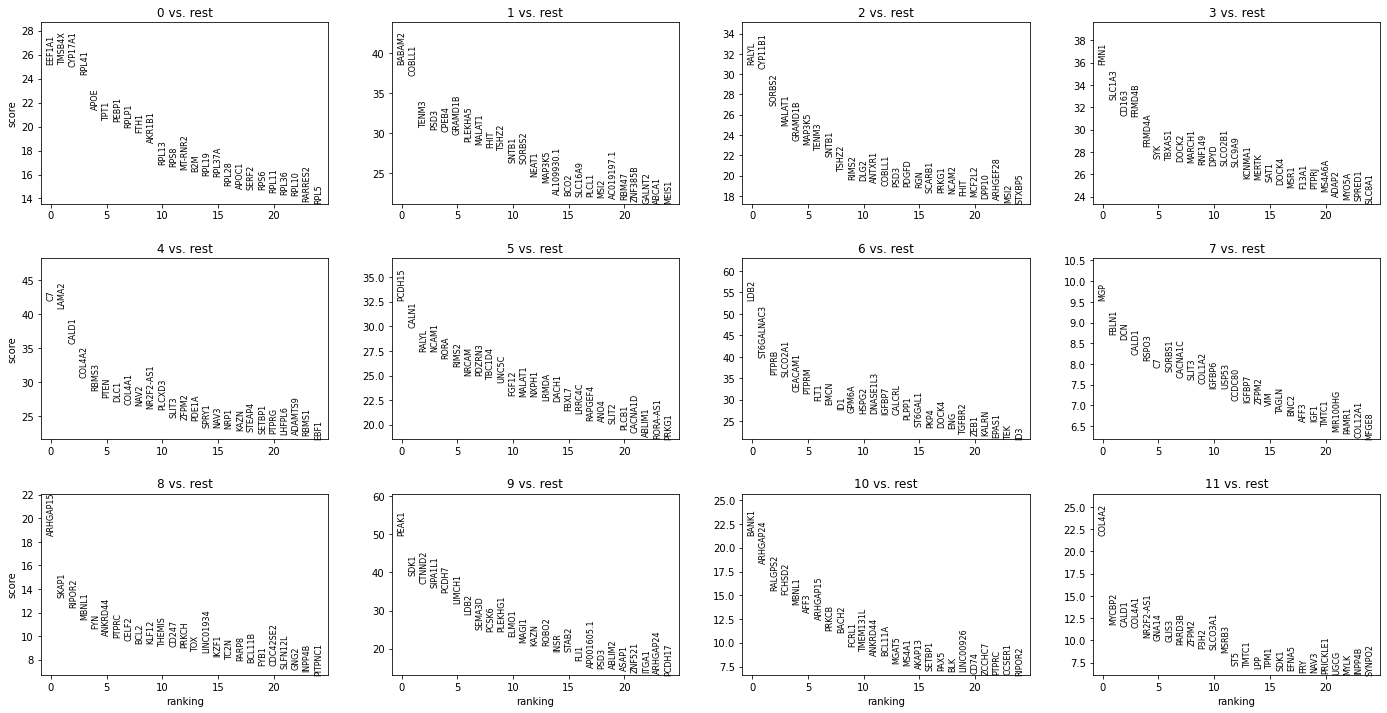

top gene names
         0       1        2       3       4       5           6      7  \
0   EEF1A1  BABAM2    RALYL    FMN1      C7  PCDH15        LDB2    MGP   
1   TMSB4X  COBLL1  CYP11B1  SLC1A3   LAMA2   CALN1  ST6GALNAC3  FBLN1   
2  CYP17A1   TENM3   SORBS2   CD163   CALD1   RALYL       PTPRB    DCN   
3    RPL41    PSD3   MALAT1  FRMD4B  COL4A2   NCAM1     SLCO2A1  CALD1   
4     APOE   CPEB4  GRAMD1B  FRMD4A   RBMS3    RORA     CEACAM1  RSPO3   

          8        9        10         11  
0  ARHGAP15    PEAK1     BANK1     COL4A2  
1     SKAP1     SDK1  ARHGAP24     MYCBP2  
2    RIPOR2   CTNND2   RALGPS2      CALD1  
3     MBNL1  SIPA1L1    FCHSD2     COL4A1  
4       FYN    PCDH7     MBNL1  NR2F2-AS1  
encode full solo rescue clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


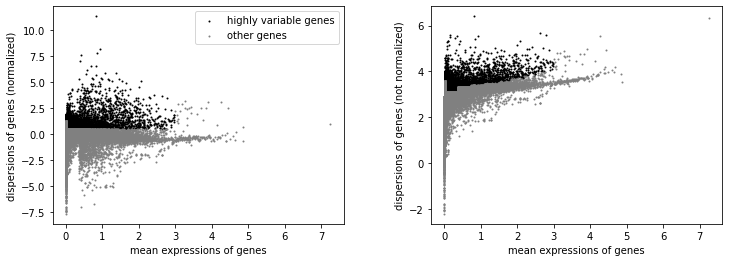

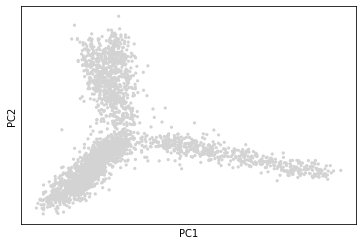

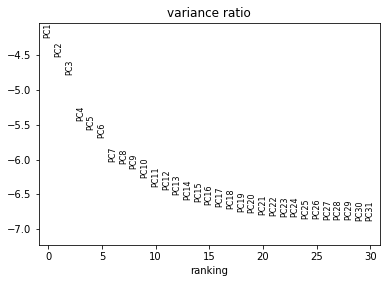

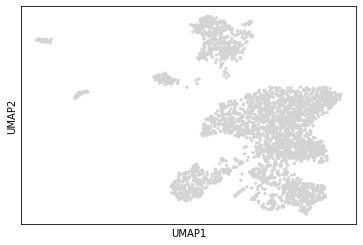

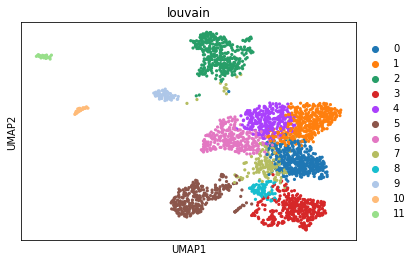

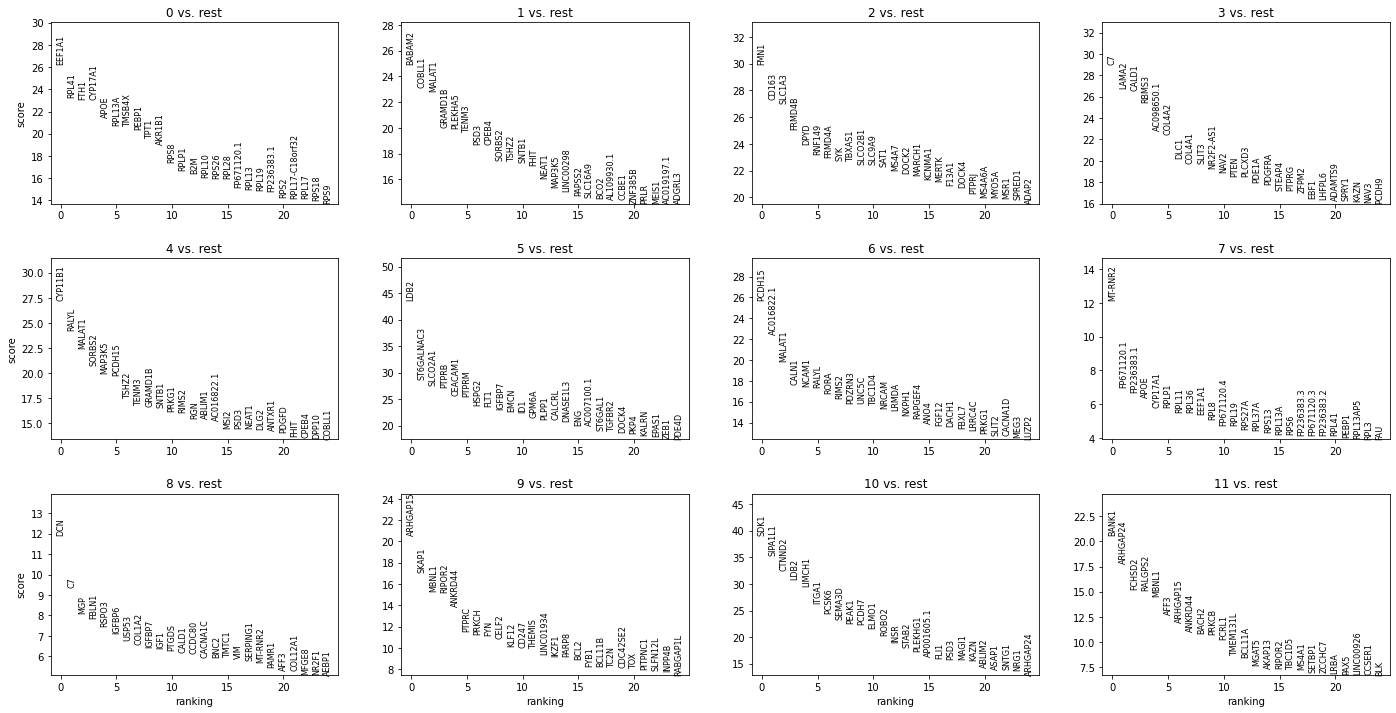

top gene names
         0        1       2           3        4           5           6  \
0   EEF1A1   BABAM2    FMN1          C7  CYP11B1        LDB2      PCDH15   
1    RPL41   COBLL1   CD163       LAMA2    RALYL  ST6GALNAC3  AC016822.1   
2     FTH1   MALAT1  SLC1A3       CALD1   MALAT1     SLCO2A1      MALAT1   
3  CYP17A1  GRAMD1B  FRMD4B       RBMS3   SORBS2       PTPRB       CALN1   
4     APOE  PLEKHA5    DPYD  AC098650.1   MAP3K5     CEACAM1       NCAM1   

            7      8         9       10        11  
0     MT-RNR2    DCN  ARHGAP15     SDK1     BANK1  
1  FP671120.1     C7     SKAP1  SIPA1L1  ARHGAP24  
2  FP236383.1    MGP     MBNL1   CTNND2    FCHSD2  
3        APOE  FBLN1    RIPOR2     LDB2   RALGPS2  
4     CYP17A1  RSPO3   ANKRD44   LIMCH1     MBNL1  
encode full solo em clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


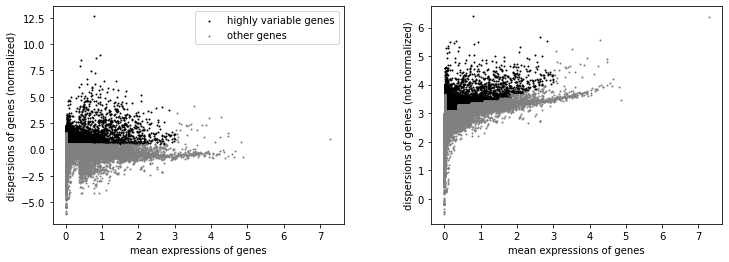

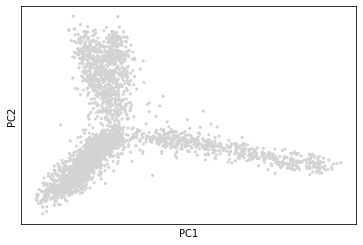

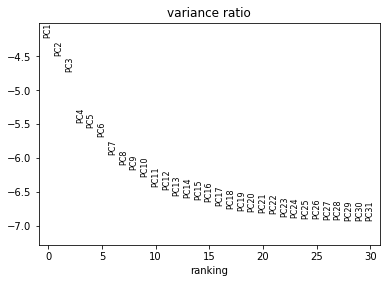

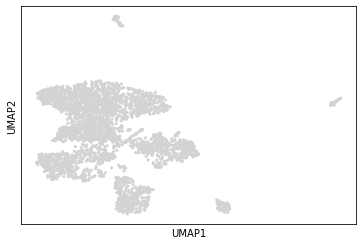

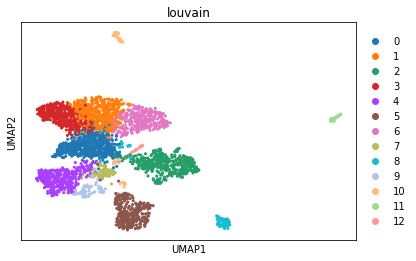

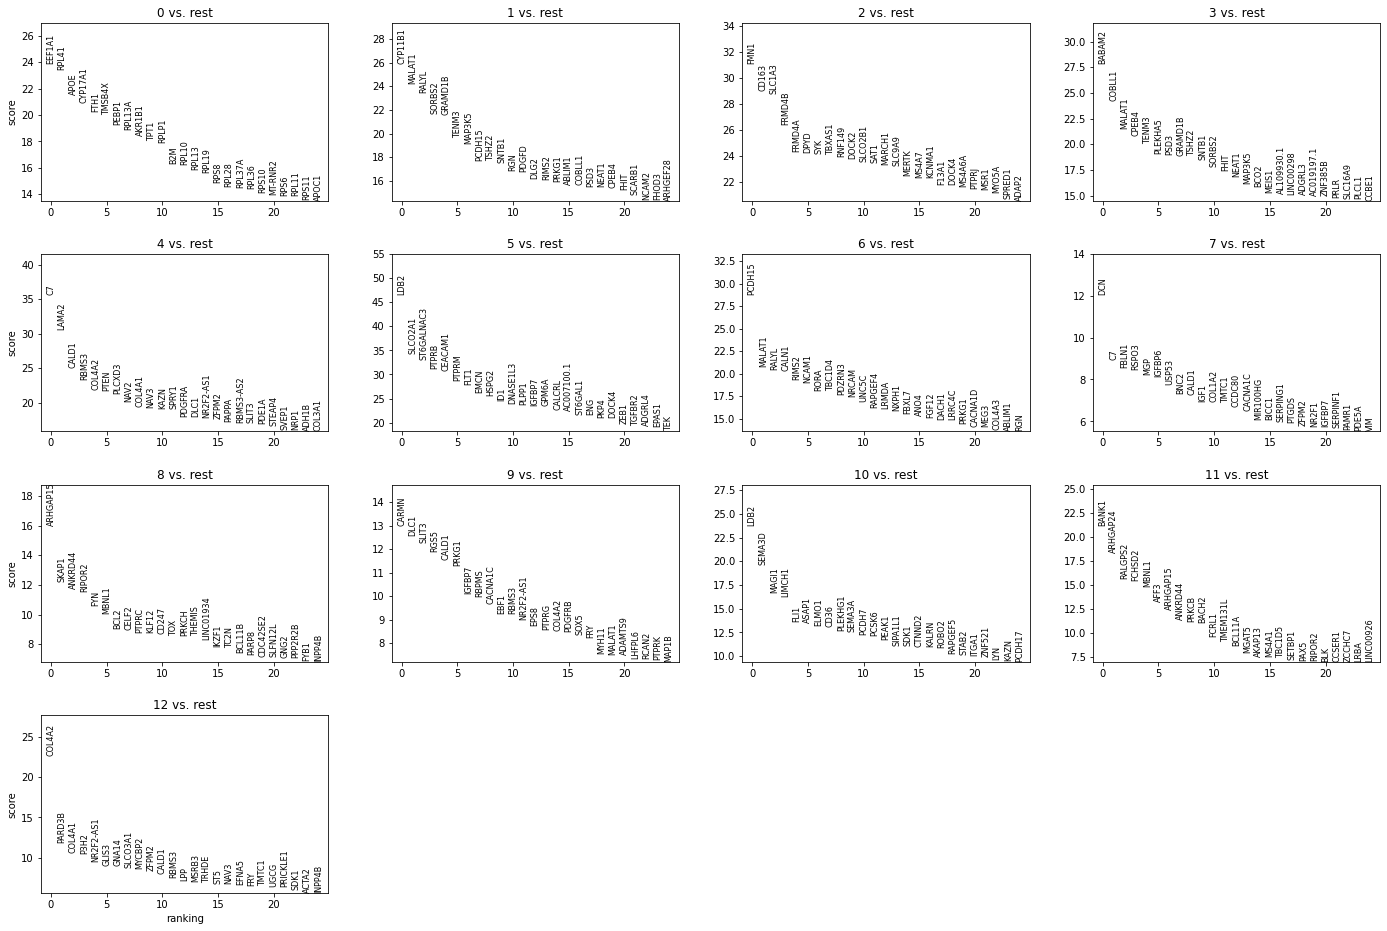

top gene names
         0        1       2       3       4           5       6      7  \
0   EEF1A1  CYP11B1    FMN1  BABAM2      C7        LDB2  PCDH15    DCN   
1    RPL41   MALAT1   CD163  COBLL1   LAMA2     SLCO2A1  MALAT1     C7   
2     APOE    RALYL  SLC1A3  MALAT1   CALD1  ST6GALNAC3   RALYL  FBLN1   
3  CYP17A1   SORBS2  FRMD4B   CPEB4   RBMS3       PTPRB   CALN1  RSPO3   
4     FTH1  GRAMD1B  FRMD4A   TENM3  COL4A2     CEACAM1   RIMS2    MGP   

          8      9      10        11         12  
0  ARHGAP15  CARMN    LDB2     BANK1     COL4A2  
1     SKAP1   DLC1  SEMA3D  ARHGAP24     PARD3B  
2   ANKRD44  SLIT3   MAGI1   RALGPS2     COL4A1  
3    RIPOR2   RGS5  LIMCH1    FCHSD2       P3H2  
4       FYN  CALD1    FLI1     MBNL1  NR2F2-AS1  
encode minimal solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


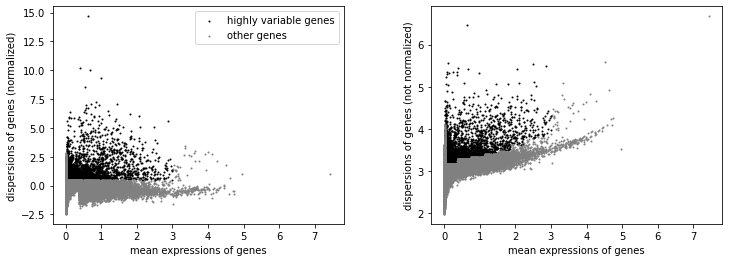

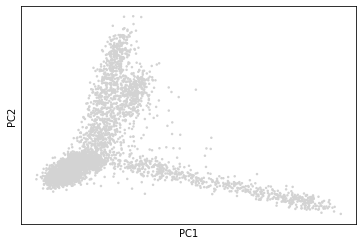

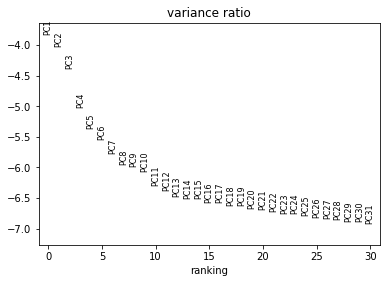

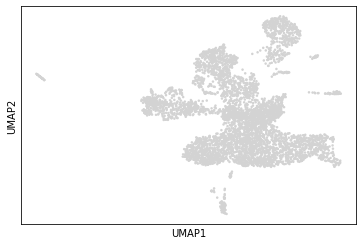

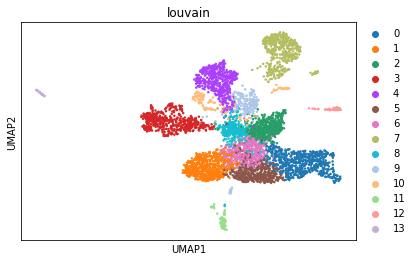

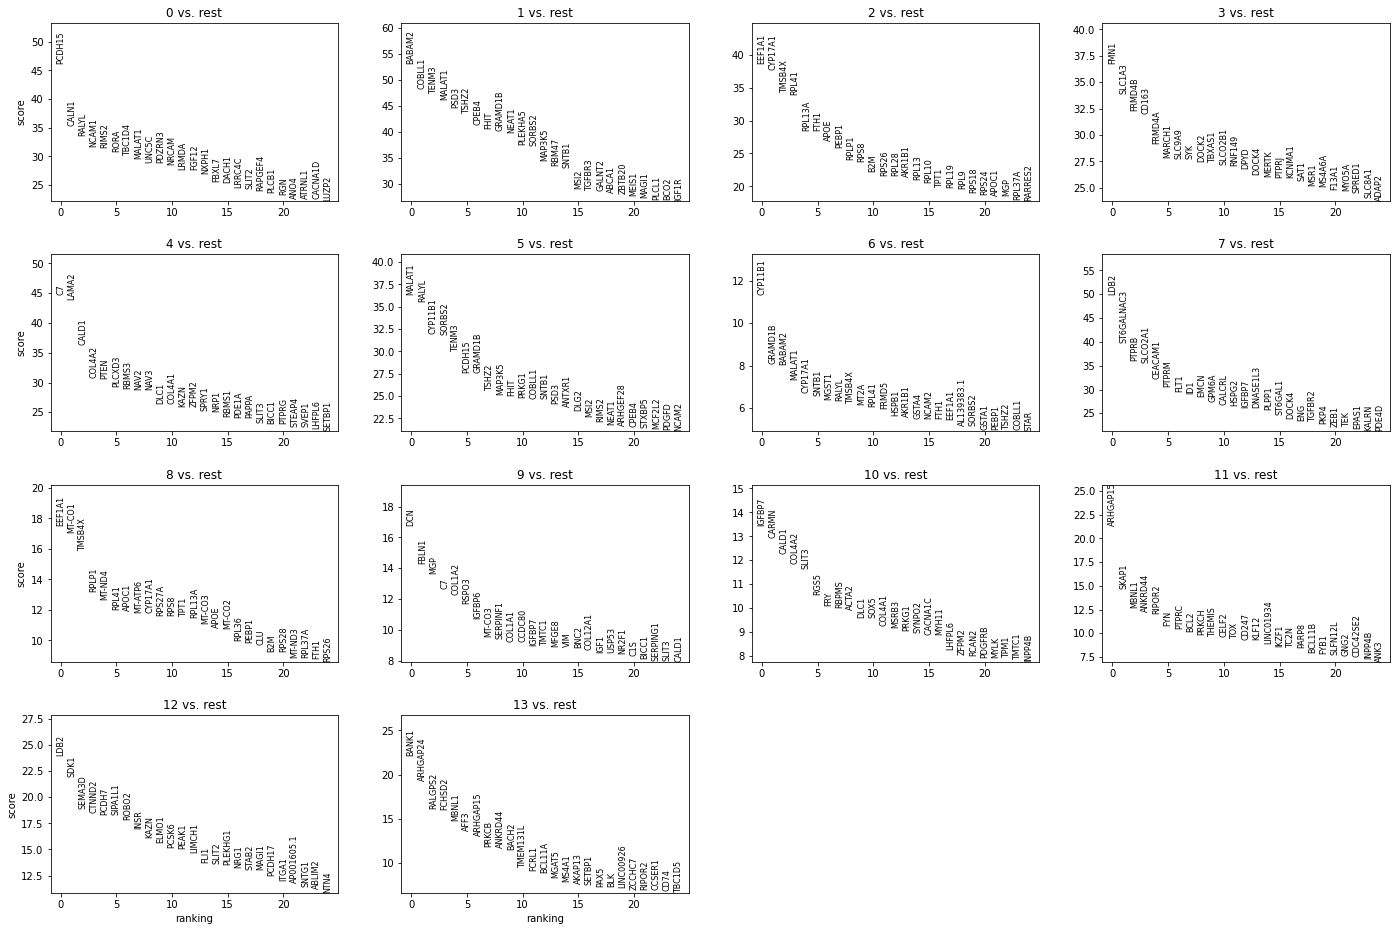

top gene names
        0       1        2       3       4        5        6           7  \
0  PCDH15  BABAM2   EEF1A1    FMN1      C7   MALAT1  CYP11B1        LDB2   
1   CALN1  COBLL1  CYP17A1  SLC1A3   LAMA2    RALYL  GRAMD1B  ST6GALNAC3   
2   RALYL   TENM3   TMSB4X  FRMD4B   CALD1  CYP11B1   BABAM2       PTPRB   
3   NCAM1  MALAT1    RPL41   CD163  COL4A2   SORBS2   MALAT1     SLCO2A1   
4   RIMS2    PSD3   RPL13A  FRMD4A    PTEN    TENM3  CYP17A1     CEACAM1   

        8       9      10        11      12        13  
0  EEF1A1     DCN  IGFBP7  ARHGAP15    LDB2     BANK1  
1  MT-CO1   FBLN1   CARMN     SKAP1    SDK1  ARHGAP24  
2  TMSB4X     MGP   CALD1     MBNL1  SEMA3D   RALGPS2  
3   RPLP1      C7  COL4A2   ANKRD44  CTNND2    FCHSD2  
4  MT-ND4  COL1A2   SLIT3    RIPOR2   PCDH7     MBNL1  
encode minimal solo rescue clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


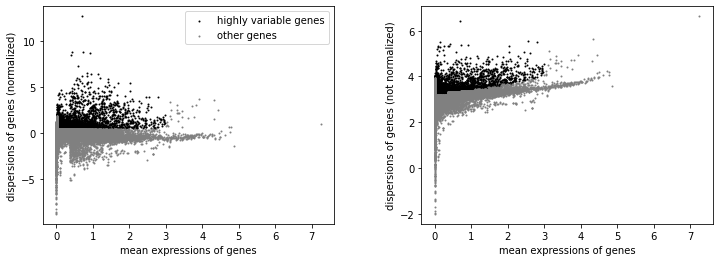

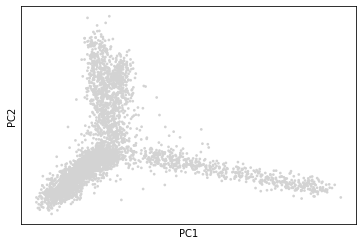

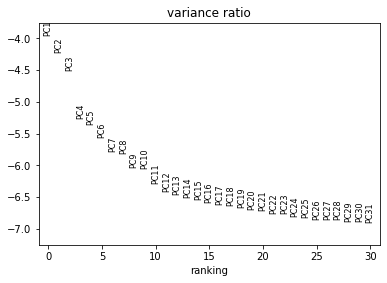

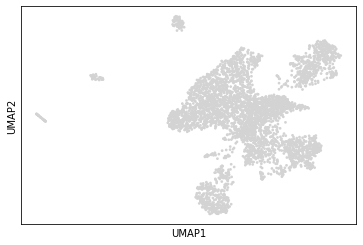

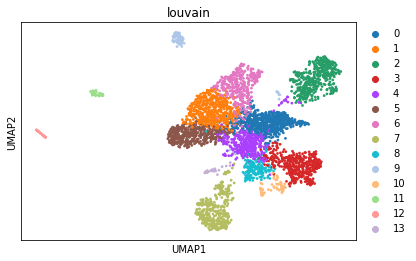

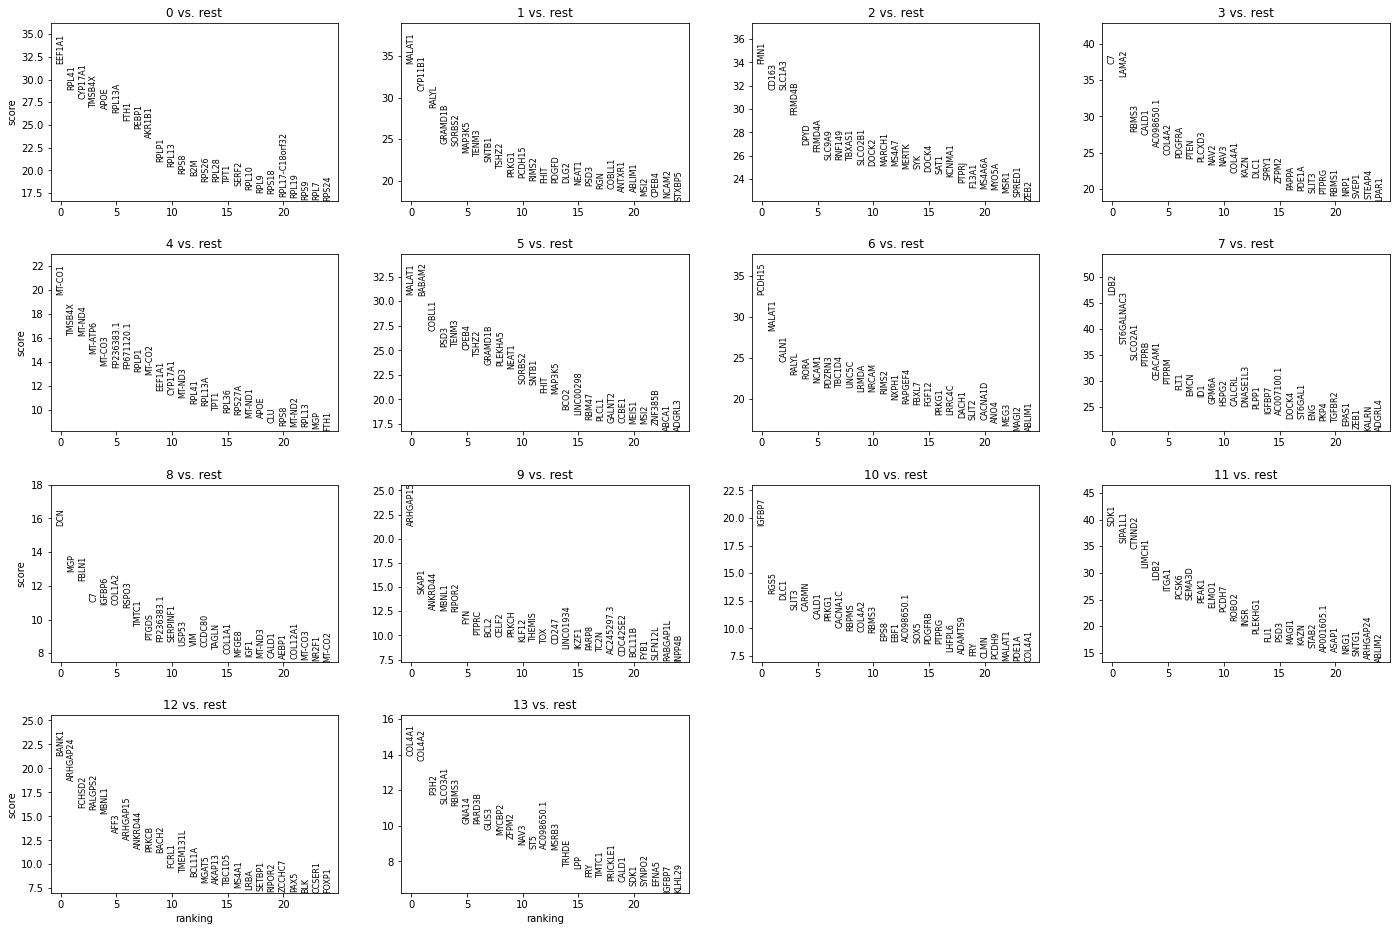

top gene names
         0        1       2           3        4       5       6           7  \
0   EEF1A1   MALAT1    FMN1          C7   MT-CO1  MALAT1  PCDH15        LDB2   
1    RPL41  CYP11B1   CD163       LAMA2   TMSB4X  BABAM2  MALAT1  ST6GALNAC3   
2  CYP17A1    RALYL  SLC1A3       RBMS3   MT-ND4  COBLL1   CALN1     SLCO2A1   
3   TMSB4X  GRAMD1B  FRMD4B       CALD1  MT-ATP6    PSD3   RALYL       PTPRB   
4     APOE   SORBS2    DPYD  AC098650.1   MT-CO3   TENM3    RORA     CEACAM1   

        8         9      10       11        12       13  
0     DCN  ARHGAP15  IGFBP7     SDK1     BANK1   COL4A1  
1     MGP     SKAP1    RGS5  SIPA1L1  ARHGAP24   COL4A2  
2   FBLN1   ANKRD44    DLC1   CTNND2    FCHSD2     P3H2  
3      C7     MBNL1   SLIT3   LIMCH1   RALGPS2  SLCO3A1  
4  IGFBP6    RIPOR2   CARMN     LDB2     MBNL1    RBMS3  
encode minimal solo em clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


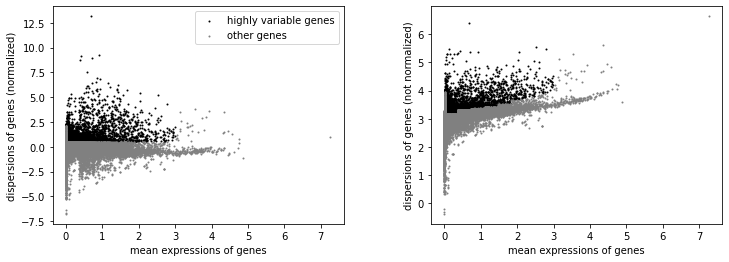

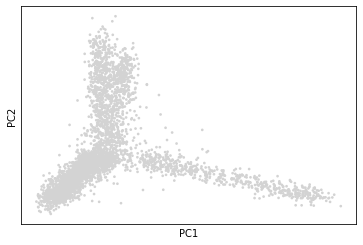

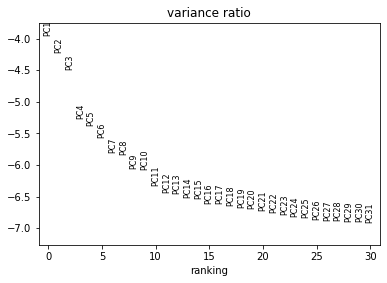

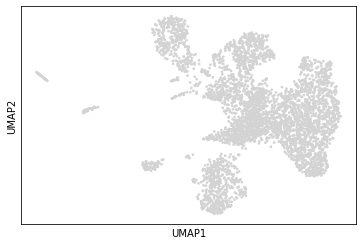

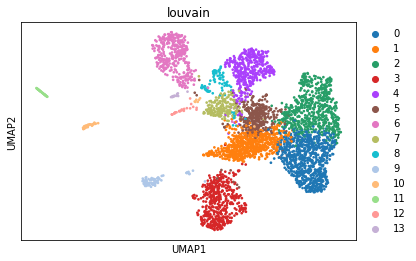

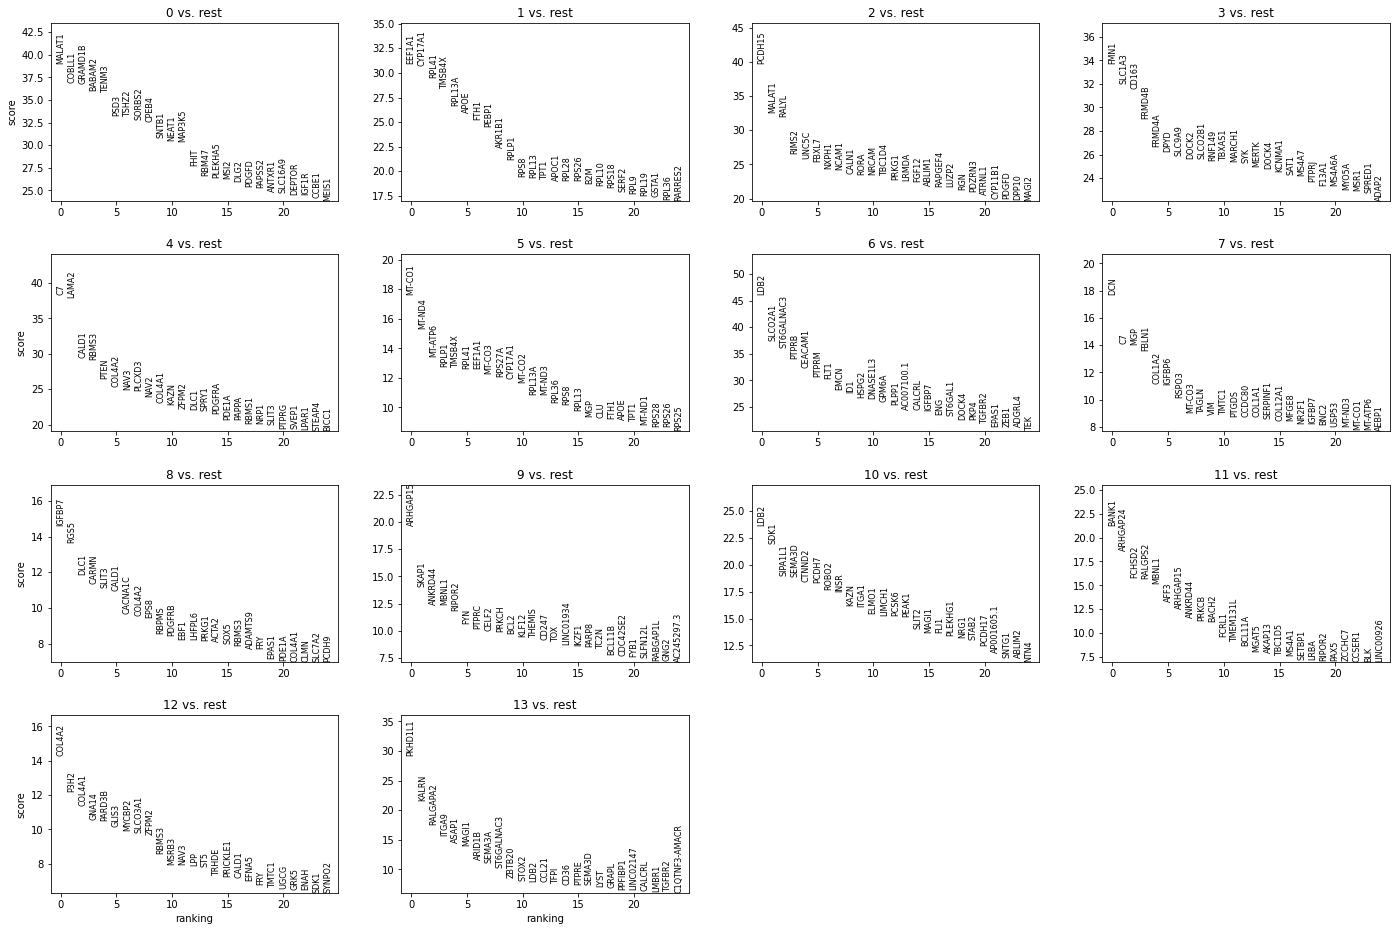

top gene names
         0        1       2       3      4        5           6       7  \
0   MALAT1   EEF1A1  PCDH15    FMN1     C7   MT-CO1        LDB2     DCN   
1   COBLL1  CYP17A1  MALAT1  SLC1A3  LAMA2   MT-ND4     SLCO2A1      C7   
2  GRAMD1B    RPL41   RALYL   CD163  CALD1  MT-ATP6  ST6GALNAC3     MGP   
3   BABAM2   TMSB4X   RIMS2  FRMD4B  RBMS3    RPLP1       PTPRB   FBLN1   
4    TENM3   RPL13A   UNC5C  FRMD4A   PTEN   TMSB4X     CEACAM1  COL1A2   

        8         9       10        11      12        13  
0  IGFBP7  ARHGAP15     LDB2     BANK1  COL4A2   PKHD1L1  
1    RGS5     SKAP1     SDK1  ARHGAP24    P3H2     KALRN  
2    DLC1   ANKRD44  SIPA1L1    FCHSD2  COL4A1  RALGAPA2  
3   CARMN     MBNL1   SEMA3D   RALGPS2   GNA14     ITGA9  
4   SLIT3    RIPOR2   CTNND2     MBNL1  PARD3B     ASAP1  


In [41]:
algorithm_scanpy_filtered = {}
algorithm_top_gene_ids = {}
algorithm_top_gene_names = {}
for algorithm in algorithm_filtered:
    #print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
    print("{algorithm} clustering".format(algorithm=algorithm))
    algorithm_scanpy_filtered[algorithm] = algorithm_filtered[algorithm][algorithm_filtered[algorithm].obs.n_genes_by_counts < 2000, :]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][algorithm_scanpy_filtered[algorithm].obs.pct_counts_mt < 2.5, :]
    
    scanpy.pp.normalize_total(algorithm_scanpy_filtered[algorithm], target_sum=30000)
    scanpy.pp.log1p(algorithm_scanpy_filtered[algorithm])
    scanpy.pp.highly_variable_genes(algorithm_scanpy_filtered[algorithm], min_mean=0.0125, max_mean=3, min_disp=0.5)
    scanpy.pl.highly_variable_genes(algorithm_scanpy_filtered[algorithm])
    algorithm_scanpy_filtered[algorithm].raw = algorithm_scanpy_filtered[algorithm]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][:, algorithm_scanpy_filtered[algorithm].var.highly_variable]
   
    scanpy.pp.regress_out( algorithm_scanpy_filtered[algorithm], ['total_counts', 'pct_counts_mt'])
    scanpy.pp.scale( algorithm_scanpy_filtered[algorithm], max_value=10)
    scanpy.tl.pca(algorithm_scanpy_filtered[algorithm], svd_solver='arpack')
    scanpy.pl.pca(algorithm_scanpy_filtered[algorithm])

    scanpy.pl.pca_variance_ratio(algorithm_scanpy_filtered[algorithm], log=True)
    
    scanpy.pp.neighbors(algorithm_scanpy_filtered[algorithm], n_neighbors=10, n_pcs=40)
    scanpy.tl.umap(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm])
    
    scanpy.tl.louvain(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm], color=['louvain'])
    
    scanpy.tl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], 'louvain', method='t-test')
    scanpy.pl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], n_genes=25, sharey=False, gene_symbols='gene_name')
    
    algorithm_top_gene_ids[algorithm] = pandas.DataFrame(algorithm_scanpy_filtered[algorithm].uns['rank_genes_groups']['names'])    
    if algorithm == "tenx solo uniq":
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v32m_gene_id_to_name.get(x, x))
    else:
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v29_gene_id_to_name.get(x, x))
    print('top gene names')
    print(algorithm_top_gene_names[algorithm].head(5))

# Cell barcodes left in common after scanpy filtering

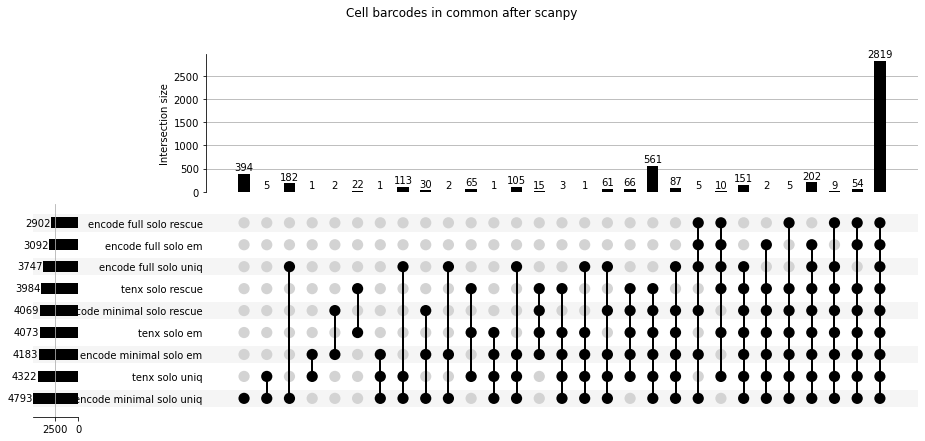

In [42]:
tutoral_barcode_set = upsetplot.from_contents({
    k: algorithm_scanpy_filtered[k].obs_names for k in algorithm_scanpy_filtered
})
f = pyplot.figure()
f.suptitle("Cell barcodes in common after scanpy")
_ = upsetplot.plot(tutoral_barcode_set, show_counts=True, fig=f)


# Gene IDs in common after scanpy filtering

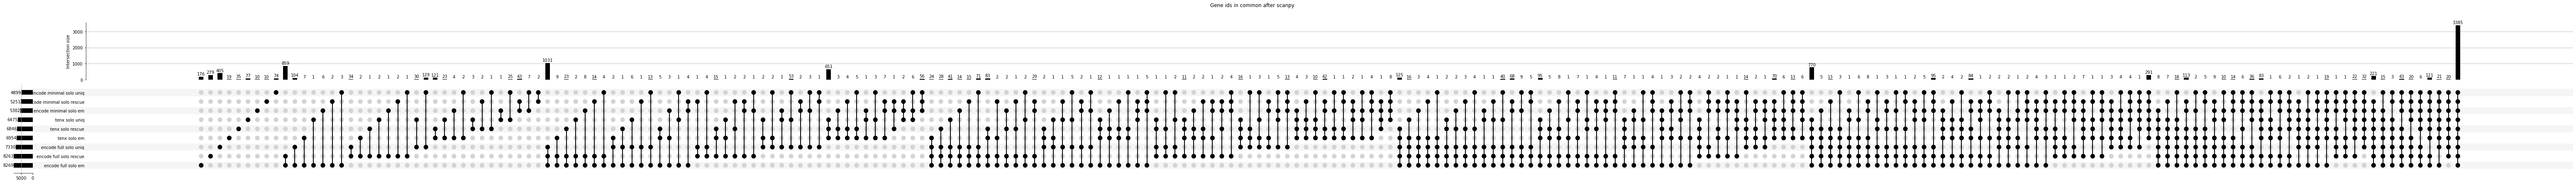

In [43]:
common_filtered_gene_base_contents = {}
for algorithm in algorithm_scanpy_filtered:
    #if algorithm == 'tenx solo uniq':
    #    common_filtered_gene_base_contents[algorithm] = {gene_id for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    #else:
    #common_filtered_gene_base_contents[algorithm] = {gene_id.split('.')[0] for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    common_filtered_gene_base_contents[algorithm] = set(algorithm_scanpy_filtered[algorithm].var_names)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
common_filtered_gene_base_set = upsetplot.from_contents(common_filtered_gene_base_contents)

f = pyplot.figure()
f.suptitle("Gene ids in common after scanpy")
_ = upsetplot.plot(common_filtered_gene_base_set, show_counts=True, fig=f)

In [44]:
common_filtered_gene_base_set

id
tenx solo uniq tenx solo rescue tenx solo em encode full solo uniq encode full solo rescue encode full solo em encode minimal solo uniq encode minimal solo rescue encode minimal solo em                    
True           True             True         False                 False                   True                True                     True                       True                    ENSG00000102575.11
                                             True                  True                    True                True                     True                       True                     ENSG00000188822.7
                                                                                                                                                                   True                    ENSG00000198947.15
                                                                                                               False                    False                      False                    ENSG00000253187.2
                                                                                                                                        True                       True                    ENSG00000171962.17
...                                                                                                                                                                                                       ...
False          False            False        False                 False                   False               False                    False                      True                     ENSG00000163364.9
                                                                                                                                                                   True                     ENSG00000255980.1
                                                                                                                                                                   True                     ENSG00000125384.6
                                                                                                                                                                   True                    ENSG00000112333.11
                                                                                                                                                                   True                    ENSG00000166928.10

[11099 rows x 1 columns]

In [45]:
#common_filtered_gene_base_set.loc[True, False, True]['id']

In [46]:
#v29_gtf.set_index('gene_id').reindex(common_filtered_gene_base_set.loc[True, False, True]['id'])

In [47]:
def build_confusion_matrix(left, right, N=20):
    confusion = {}
    for cluster in left:
        for gene in left[cluster].head(N):
            confusion.setdefault(gene, {})['left'] = int(cluster)

    for cluster in right:
        for gene in right[cluster].head(N):
            confusion.setdefault(gene, {})['right'] = int(cluster)

    last_left = int(left.columns[-1]) + 1
    last_right = int(right.columns[-1]) + 1

    confusion_matrix = numpy.zeros((last_left+1, last_right+1))

    for gene in confusion:
        x = confusion[gene].get('left', last_left)
        y = confusion[gene].get('right', last_right)
        confusion_matrix[x,y] += 1
    return confusion_matrix

# Confusion matrices between top N genes in each cluster

In [48]:
def plot_algorithm_confusion(table, programs=None, N=20):
    if programs is None:
        programs = list(table.keys())
    confusion = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            cm = build_confusion_matrix(table[name_x], table[name_y], N)
            seaborn.heatmap(cm, annot=False, ax=ax)
            
            if x == 0:
                ax.set_ylabel(name_y)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Gene name confusion matrix of top {} genes".format(N))
    #f.tight_layout()


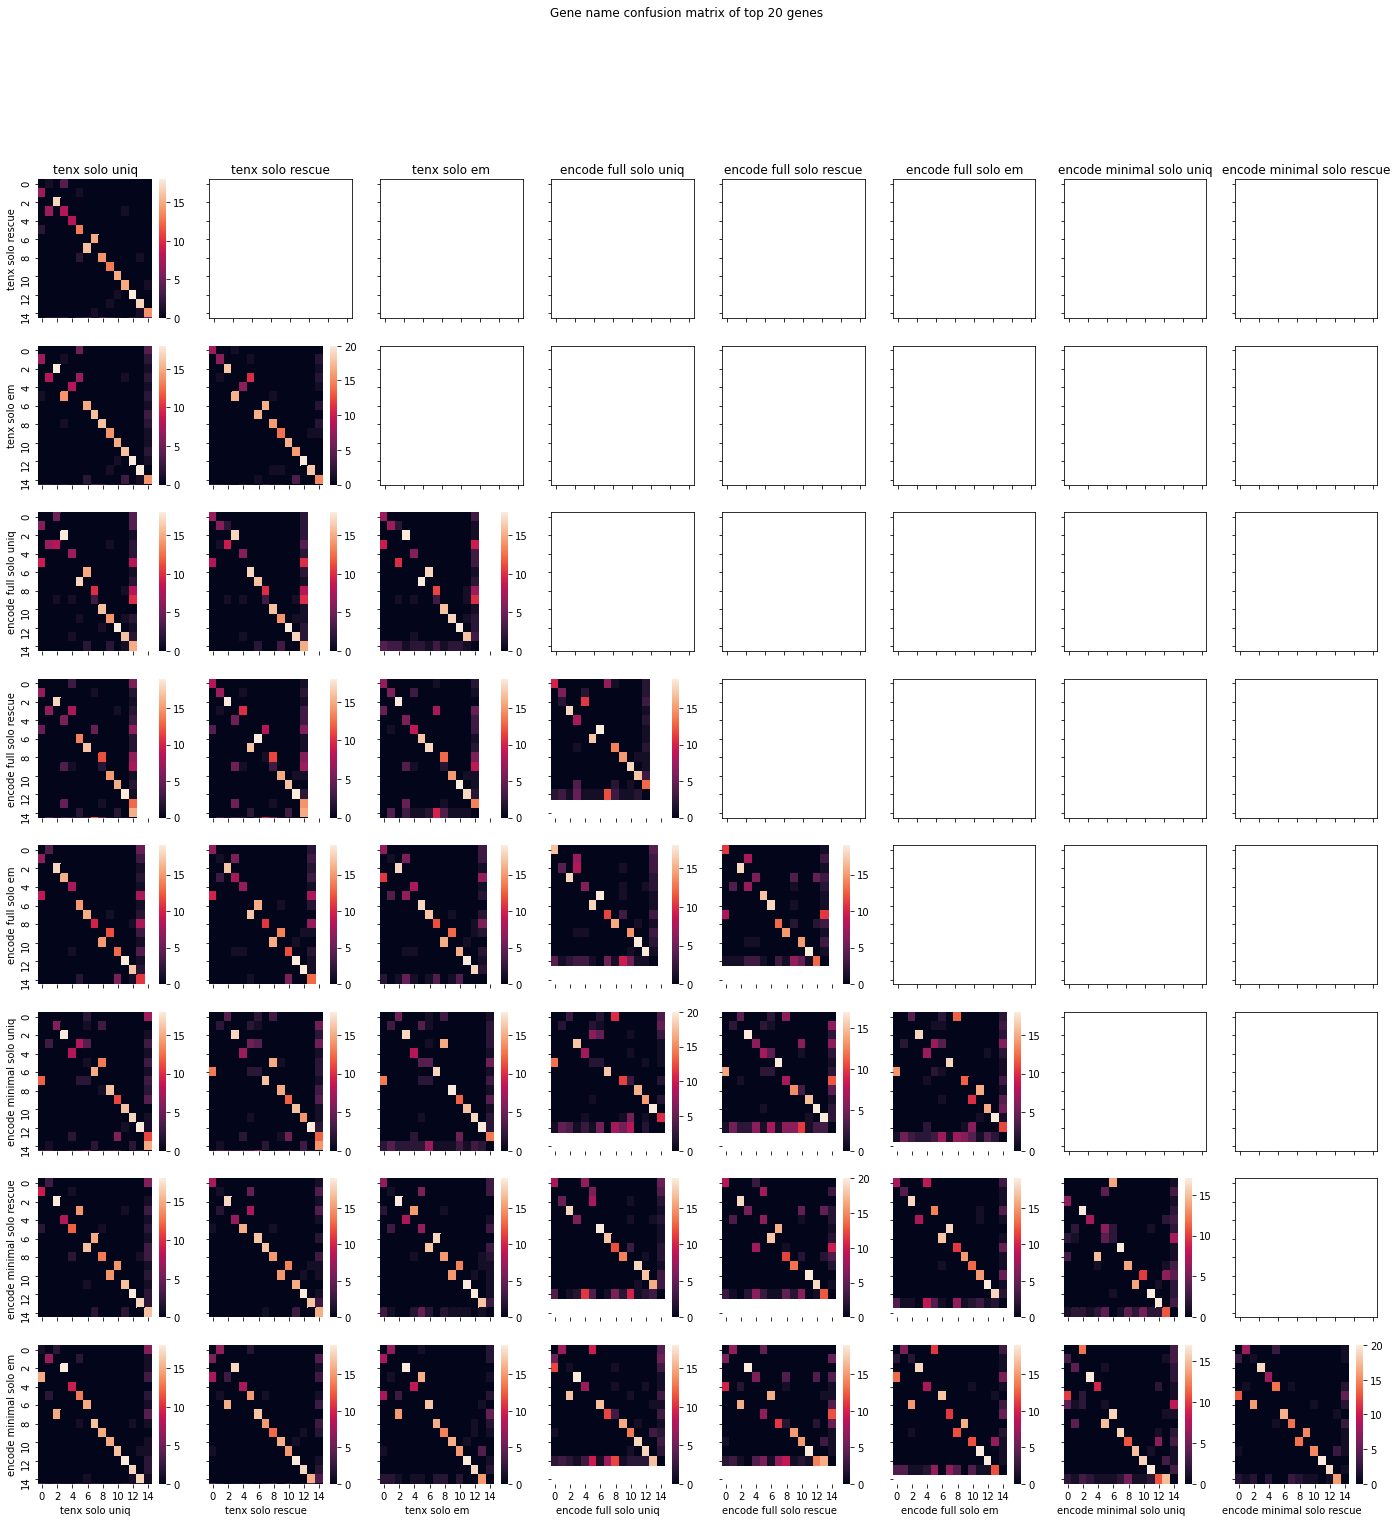

In [49]:
plot_algorithm_confusion(algorithm_top_gene_names, N=20)

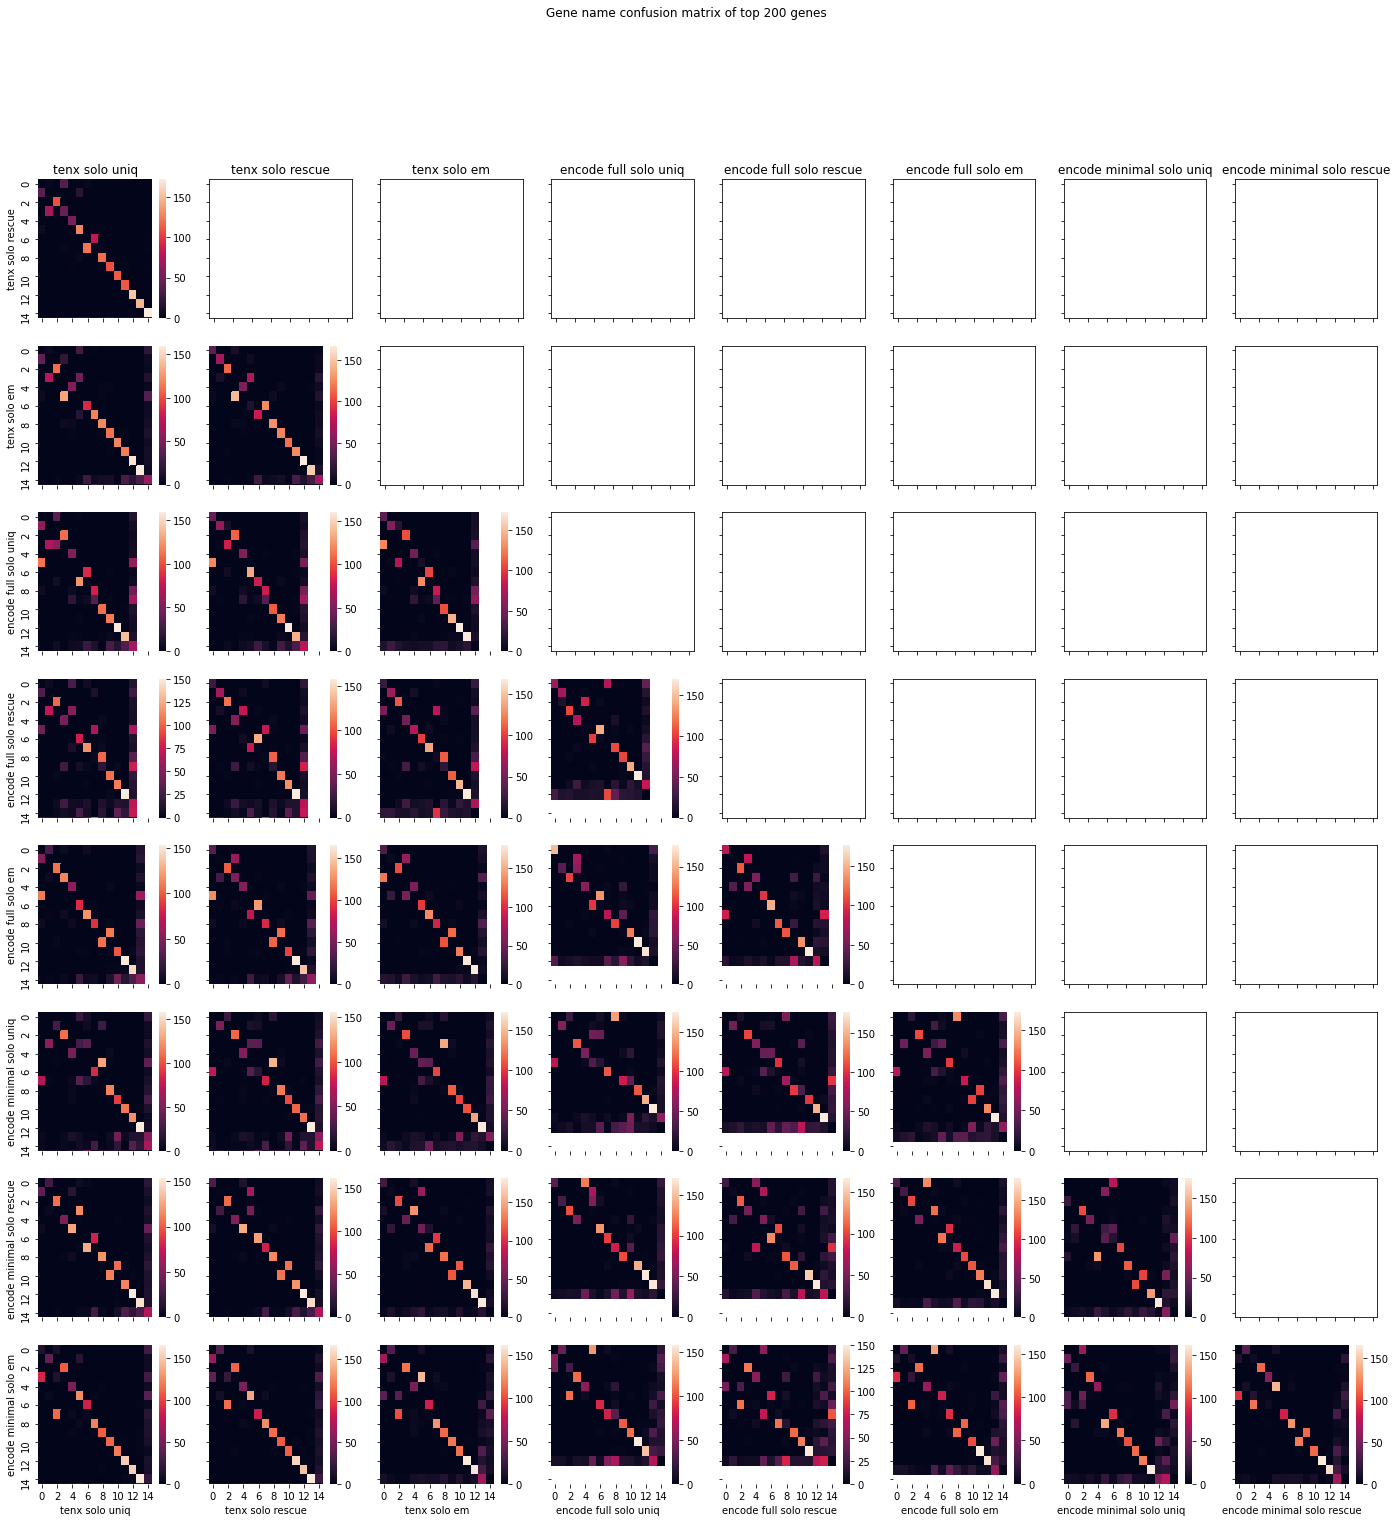

In [50]:
plot_algorithm_confusion(algorithm_top_gene_names, N=200)

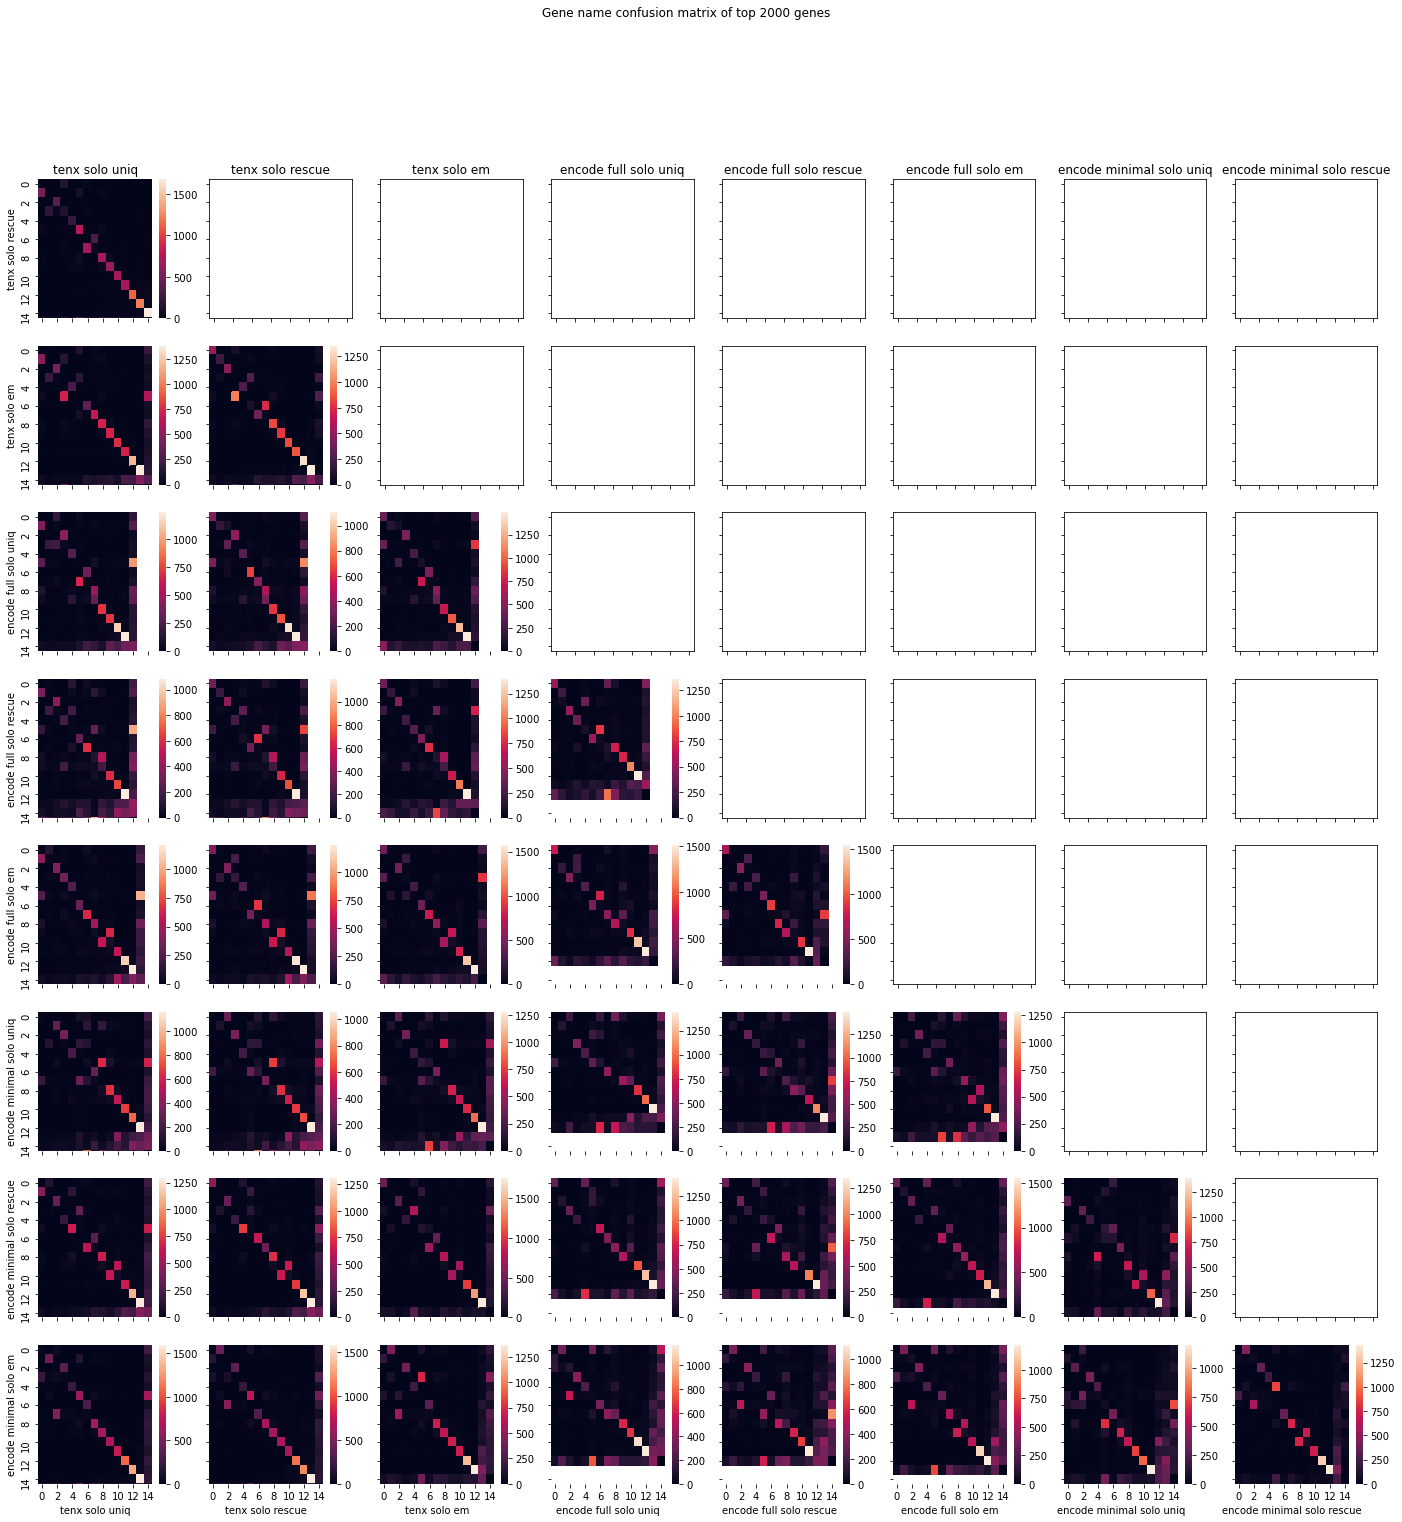

In [51]:
plot_algorithm_confusion(algorithm_top_gene_names, N=2000)

# Save h5 tables

In [52]:
for algorithm in algorithm_scanpy_filtered:
    run_dir, quantification, filtering, multiread = algorithm_roots[algorithm]
    h5ad_name = "{}_{}_{}.h5ad".format(quantification, "scanpy", multiread)
    algorithm_scanpy_filtered[algorithm].write_h5ad(run_dir / h5ad_name)